# Capstone Project: Creating Zelda Music Using Data from Midi Files

Fan-generated midi files for The Legend of Zelda were obtained for the purpose of this project. In each is stored the data extracted here for analysis. [1]

## Problem Statement

Can data extracted from fan-generated midi files created to imitate music from The Legend of Zelda be used to generate similar sounding music? What insights are hidden in this data and what can they reveal about similar music to that of The Legend of Zelda?

## Executive Summary

***

<center>**Under Construction**</center>

Venenatis justo odio condimentum etiam tortor orci primis, a rutrum porta rutrum vulputate erat nibh, erat curabitur viverra est aliquam potenti porttitor dui adipiscing platea nunc gravida etiam.

Hendrerit sagittis tellus sodales nullam feugiat iaculis aliquet fames, ante aptent posuere lorem id posuere rhoncus sodales litora, sollicitudin aenean cras rutrum interdum lectus velit amet curabitur sapien auctor nunc varius.

Eleifend mattis in vehicula curabitur vestibulum mollis cras, sem ligula scelerisque tortor molestie curae fermentum mollis, sem nisl hendrerit lacus habitasse metus tellus, sed aliquam eget bibendum pulvinar curabitur.

<center>**Under Construction**</center>

***

## Data Dictionary

|Feature|Type|Description|
|---|---|---|
|type|object|whether row represents a note or chord|
|name|object|letter(s) corresponding to note(s) played|
|pitch_midi_value|int|midi value(s) of pitch for note(s) played|
|velocity|int|midi value(s) of forcefulness by which note(s) is/are played|
|duration name|object|name of note duration|
|duration value|float|how long note(s) are played in number of beats|
|prior rest time|float|how long before first or next note is played in number of beats|
|start time|float|number of beats before note is played|

### Contents:
- [Import Statements](#Import-Statements)
- [Extracting Data from Midi Files](#Extracting-Data-from-Midi-Files)
- [Extracting Additional Data](#Extracting-Additional-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Modeling](#Data-Modeling)
- [Simulating Zelda Music](#Simulating-Zelda-Music)
- [Conclusions and Future Goals](#Conclusions-and-Future-Goals)
- [References](#References)

## Import Statements

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import music21
import re
import os
from mido import Message, MidiFile, MidiTrack

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

%matplotlib inline

## Extracting Data from Midi Files

In [304]:
input_midi = "The Legend of Zelda Ocarina of Time - Zeldas Theme.mid"
translated_midi = music21.midi.translate.midiFilePathToStream(f'input_midi_files/{input_midi}')

In [305]:
parts_list = [item for item in translated_midi]

parts_list

[<music21.stream.Part 0x1a5c627048>]

In [306]:
# checking for substreams
substreams_check = {}
counter = 0
for part in parts_list:
    substreams_check[counter] = False
    for item in part:
        if 'stream' in str(item):
            substreams_check[counter] = True
            break
    counter += 1

# adding all music streams
list_of_streams = []
for key in substreams_check.keys():   
    if substreams_check[key] == True:
        for item in parts_list[key]:
            if 'stream' in str(item):
                list_of_streams.append(item)
    else:
        list_of_streams.append(parts_list[key])

In [307]:
list_of_streams

[<music21.stream.Voice 0x1a5c8561d0>,
 <music21.stream.Voice 0x1a5c856208>,
 <music21.stream.Voice 0x1a5c856240>,
 <music21.stream.Voice 0x1a5c856278>]

In [308]:
for note in list_of_streams[0][:20]:
    print(note)

<music21.note.Note F#>
<music21.note.Note D>
<music21.note.Note A>
<music21.note.Note D>
<music21.note.Note F#>
<music21.note.Note G#>
<music21.note.Note E>
<music21.note.Note B>
<music21.note.Note E>
<music21.note.Note A>
<music21.note.Note F>
<music21.note.Note C>
<music21.note.Note F>
<music21.note.Note B>
<music21.note.Note D>
<music21.note.Note F>
<music21.note.Note B>
<music21.note.Note D>
<music21.note.Note B>
<music21.note.Note D>


In [309]:
for item in list_of_streams[0][:20]:
    if type(item) == music21.chord.Chord:
        print(item.pitchNames, [p.midi for p in item.pitches], item.duration.fullName, item.duration.quarterLength)
    elif type(item) == music21.note.Note:
        print(item.name, item.pitch.midi, item.duration.fullName, item.duration.quarterLength)

F# 78 16th 0.25
D 74 16th 0.25
A 69 16th 0.25
D 74 16th 0.25
F# 78 Zero 0.0
G# 80 16th 0.25
E 76 16th 0.25
B 71 16th 0.25
E 76 16th 0.25
A 81 16th 0.25
F 77 16th 0.25
C 72 16th 0.25
F 77 16th 0.25
B 71 16th 0.25
D 74 16th 0.25
F 77 16th 0.25
B 83 16th 0.25
D 86 Half Tuplet of 6/5ths (1 2/3 QL) 5/3
B 71 Half 2.0
D 74 Quarter 1.0


In [310]:
# preparing dictionary with soon-to-be data frames per stream
streams = {}
for instrument in range(len(list_of_streams)):
    streams[instrument] = {'type': [],
                           'name': [],
                           'pitch_midi_value': [],
                           'duration_name': [],
                           'duration_value': []}

# adding values to streams dictionary
for instrument in range(len(list_of_streams)):
    for note_loc in range(len(list_of_streams[instrument])):
        if (type(list_of_streams[instrument][note_loc]) == music21.note.Note) & (list_of_streams[instrument][note_loc].duration.quarterLength != 0):
            streams[instrument]['type'].append('note')
            streams[instrument]['name'].append(list_of_streams[instrument][note_loc].name)
            streams[instrument]['pitch_midi_value'].append(list_of_streams[instrument][note_loc].pitch.midi)
            streams[instrument]['duration_name'].append(list_of_streams[instrument][note_loc].duration.fullName)
            streams[instrument]['duration_value'].append(list_of_streams[instrument][note_loc].duration.quarterLength)
        elif (type(list_of_streams[instrument][note_loc]) == music21.chord.Chord) & (list_of_streams[instrument][note_loc].duration.quarterLength != 0):
            streams[instrument]['type'].append('chord')
            streams[instrument]['name'].append(tuple(list_of_streams[instrument][note_loc].pitchNames))
            streams[instrument]['pitch_midi_value'].append(tuple(p.midi for p in list_of_streams[instrument][note_loc].pitches))
            streams[instrument]['duration_name'].append(list_of_streams[instrument][note_loc].duration.fullName)
            streams[instrument]['duration_value'].append(list_of_streams[instrument][note_loc].duration.quarterLength)

In [311]:
# creating data frames
dataframes = {}
for key in streams.keys():
    dataframes[key] = pd.DataFrame(streams[key])

In [312]:
# creating midi for each instrument in list_of_streams
midi_dict = {}
for item_position in range(len(list_of_streams)):
    midi_dict[item_position] = music21.midi.translate.streamToMidiFile(list_of_streams[item_position])

# converting midi contents to string for parsing
midi_string = {}
for key in midi_dict.keys():
    midi_string[key] = str(midi_dict[key])

# regex'd list of items from midi_string's
regex = {}
for key in midi_string.keys():
    regex[key] = re.findall('<(.[^>]*)', midi_string[key])

In [313]:
# extracting velocities from NOTE_ON MidiEvents
velocities = {}
for key in midi_string.keys():
    regex_velocities = pd.Series(re.findall('velocity=(.[^>]*)', midi_string[key]))
    on_off_booleans = [True if status == 'NOTE_ON' else False for status in re.findall('NOTE_O[NF]F?', midi_string[key])]
    velocities[key] = list(regex_velocities[on_off_booleans])

# creating list numbers corresponding to how many notes per rest/note/chord
for key in dataframes.keys():
    list_of_note_numbers = []
    for i in dataframes[key].index:
        if dataframes[key].iloc[i, 0] == 'note':
            list_of_note_numbers.append(1)
        else:
            list_of_note_numbers.append(len(dataframes[key].iloc[i, 1]))

# appending number of velocity values equal to number of notes per rest/note/chord  
    position = 0
    list_of_velocity_lists = []
    for number in list_of_note_numbers:
        if number == 1:
            list_of_velocity_lists.append(velocities[key][position])
        else:
            list_of_velocity_lists.append(tuple(velocities[key][position:position + number]))
        position += number

    dataframes[key]['velocity'] = list_of_velocity_lists

In [314]:
# adding values for all implicit rest times occuring before notes are played
# adding values for start time of each note
for key in dataframes.keys():
    list_of_implicit_rest_times = []
    counter = 0
    for i in range(len(dataframes[key]['pitch_midi_value'])):
        if i == 0:
            previous_note_duration = 0
        else:
            previous_note_duration = dataframes[key]['duration_value'][i-1]           
        pitch = dataframes[key]['pitch_midi_value'][i]
        if type(pitch) == tuple:
            pitch = pitch[0]
        implicit_rest_time = 0
        for j in range(counter, len(regex[key])):
            if (('NOTE_ON' in regex[key][j]) & (f'pitch={pitch}' in regex[key][j])):
                implicit_rest_time = abs(implicit_rest_time - previous_note_duration)
                list_of_implicit_rest_times.append(implicit_rest_time)
                counter = j + 1
                break
            else:
                implicit_rest_time += music21.midi.translate.midiToDuration(re.findall('t=(\d\d?\d?\d?\d?)', regex[key][j])[0]).quarterLength

    dataframes[key]['prior_rest_time'] = list_of_implicit_rest_times
    dataframes[key]['start_time'] = dataframes[key]['prior_rest_time'].cumsum() + dataframes[key]['duration_value'].shift(1).fillna(0).cumsum()

In [315]:
name = input_midi.replace(' ', '_').replace('.mid', '')

for key in dataframes.keys():
    dataframes[key]['song'] = name
    dataframes[key]['stream'] = key  
    column_arrangement = ['song', 'stream', 'type', 'name', 'pitch_midi_value', 'velocity', 'duration_name', 'duration_value', 'prior_rest_time', 'start_time']
    dataframes[key] = dataframes[key].reindex(columns=column_arrangement)
    dataframes[key].to_csv(f'output_data_frames/df_{key}___{name}.csv', index=False)
    
for key in midi_dict.keys():
    midi_dict[key].open(f'output_midi_files/midi_{key}___{name}.mid', 'wb')
    midi_dict[key].write()
    midi_dict[key].close()

In [316]:
regex[0]

['MidiFile 1 tracks\n  <MidiTrack 1 -- 582 events\n    <MidiEvent DeltaTime, t=0, track=1, channel=1',
 "MidiEvent SEQUENCE_TRACK_NAME, t=0, track=1, channel=1, data=b''",
 'MidiEvent DeltaTime, t=0, track=1, channel=1',
 'MidiEvent PITCH_BEND, t=0, track=1, channel=1, parameter1=0, parameter2=64',
 'MidiEvent DeltaTime, t=0, track=1, channel=1',
 'MidiEvent NOTE_ON, t=0, track=1, channel=1, pitch=78, velocity=62',
 'MidiEvent DeltaTime, t=256, track=1, channel=1',
 'MidiEvent NOTE_OFF, t=0, track=1, channel=1, pitch=78, velocity=0',
 'MidiEvent DeltaTime, t=0, track=1, channel=1',
 'MidiEvent NOTE_ON, t=0, track=1, channel=1, pitch=74, velocity=62',
 'MidiEvent DeltaTime, t=256, track=1, channel=1',
 'MidiEvent NOTE_OFF, t=0, track=1, channel=1, pitch=74, velocity=0',
 'MidiEvent DeltaTime, t=0, track=1, channel=1',
 'MidiEvent NOTE_ON, t=0, track=1, channel=1, pitch=69, velocity=63',
 'MidiEvent DeltaTime, t=256, track=1, channel=1',
 'MidiEvent NOTE_OFF, t=0, track=1, channel=1, pit

## Extracting Additional Data

In [242]:
# running script on all other midi files
'''!python midi_to_df.py "The Legend of Zelda Ocarina of Time - Title Theme.mid"
!python midi_to_df.py "The Legend of Zelda Ocarina of Time - Great Fairy Fountain.mid"
!python midi_to_df.py "The Legend of Zelda Twilight Princess - Hyrule Castle.mid"
!python midi_to_df.py "The Legend of Zelda Ocarina of Time - Hyrule Field.mid"
!python midi_to_df.py "The Legend of Zelda Ocarina of Time - Kokiri Forest.mid"
!python midi_to_df.py "The Legend of Zelda Ocarina of Time - Lost Woods.mid"
!python midi_to_df.py "The Legend of Zelda Ocarina of Time - Gerudo Valley.mid"
!python midi_to_df.py "The Legend of Zelda The Wind Waker - Dragon Roost Island.mid"
!python midi_to_df.py "Zelda - Majora's Mask - Song of Healing.mid"
!python midi_to_df.py "The Legend of Zelda Majoras Mask - Song of Double Time.mid"
!python midi_to_df.py "Zelda - Ocarina of Time - Song of Storms.mid"''';

In [263]:
# add and combine data into single data frame
df = pd.DataFrame()
list_of_csv_data = os.listdir("output_data_frames")
for csv in list_of_csv_data:
    if '.csv' in csv:
        df = df.append(pd.read_csv(f'output_data_frames/{csv}'))    

## Data Cleaning

In [228]:
df.head()

,song,stream,type,name,pitch_midi_value,velocity,duration_name,duration_value,prior_rest_time,start_time
0,The_Legend_of_Zelda_Twilight_Princess_-_Hyrule...,1,chord,"('D', 'G')","(62, 67)","('44', '54')",16th,0.25,10.149414,10.149414
1,The_Legend_of_Zelda_Twilight_Princess_-_Hyrule...,1,chord,"('D', 'G')","(62, 67)","('44', '54')",16th,0.25,0.000000,10.399414
2,The_Legend_of_Zelda_Twilight_Princess_-_Hyrule...,1,chord,"('D', 'G')","(62, 67)","('56', '70')",Eighth,0.5,0.000000,10.649414
3,The_Legend_of_Zelda_Twilight_Princess_-_Hyrule...,1,chord,"('E-', 'G#')","(63, 68)","('56', '70')",Eighth,0.5,0.000000,11.149414
4,The_Legend_of_Zelda_Twilight_Princess_-_Hyrule...,1,chord,"('F', 'B-')","(65, 70)","('56', '70')",Eighth Triplet (1/3 QL),1/3,0.000000,11.649414


In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7720 entries, 0 to 735
Data columns (total 10 columns):
song                7720 non-null object
stream              7720 non-null int64
type                7720 non-null object
name                7720 non-null object
pitch_midi_value    7720 non-null object
velocity            7720 non-null object
duration_name       7720 non-null object
duration_value      7720 non-null object
prior_rest_time     7720 non-null float64
start_time          7720 non-null float64
dtypes: float64(2), int64(1), object(7)
memory usage: 663.4+ KB


In [230]:
# expanding chords in data frame
df_chords = df[df['type'] == 'chord'].reset_index(drop=True)
df_chords_expanded = pd.DataFrame()
for i in range(df_chords.shape[0]):
    for j in range(len(tuple(re.findall('[A-G][#-]?', df_chords['name'][i])))):
        df_chord_extracted = df_chords.iloc[i, :].copy()
        df_chord_extracted['name'] = tuple(re.findall('[A-G][#-]?', df_chords['name'][i]))[j]
        df_chord_extracted['pitch_midi_value'] = tuple(re.findall('\d\d?\d?', df_chords['pitch_midi_value'][i]))[j]
        df_chord_extracted['velocity'] = tuple(re.findall('\d\d?\d?', df_chords['velocity'][i]))[j]
        df_chords_expanded = df_chords_expanded.append(df_chord_extracted, ignore_index=True)
        
df = df[df['type'] != 'chord'].append(df_chords_expanded, sort=False).sort_values(by=['song', 'stream', 'start_time']).reset_index(drop=True)

In [231]:
converted_duration = []

for each in df['duration_value']:
    # if it's already a float, append:
    if type(each) == float:
        converted_duration.append(each)
        
    # if not:
    else:
        try:
            # if it's easy to convert to a float, append:
            new_each = float(each)
            new_each = np.round(new_each, decimals=3)
            converted_duration.append(new_each)
        except:
            # if not, split on the backslash and divide:
            num, den = each.split('/')
            new_each = np.round(int(num)/int(den), decimals=3)
            converted_duration.append(new_each)
            
df['duration_value'] = converted_duration

In [235]:
# converting numeric columns into appropriate numeric types 
df['pitch_midi_value'] = df['pitch_midi_value'].map(lambda cell: int(cell))
df['velocity'] = df['velocity'].map(lambda cell: int(cell))
df['start_time'] = df['start_time'].map(lambda cell: float(cell))

# converting stream back to int
df['stream'] = df['stream'].map(lambda cell: int(cell))

In [236]:
df.head()

,song,stream,type,name,pitch_midi_value,velocity,duration_name,duration_value,prior_rest_time,start_time
0,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,69,46,Eighth,0.5,0.0,0.0
1,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,81,56,Eighth,0.5,0.0,0.0
2,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,69,41,Eighth,0.5,0.0,0.5
3,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,81,55,Eighth,0.5,0.0,0.5
4,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,D,62,41,Eighth,0.5,0.0,1.0


In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13934 entries, 0 to 13933
Data columns (total 10 columns):
song                13934 non-null object
stream              13934 non-null int64
type                13934 non-null object
name                13934 non-null object
pitch_midi_value    13934 non-null int64
velocity            13934 non-null int64
duration_name       13934 non-null object
duration_value      13934 non-null float64
prior_rest_time     13934 non-null float64
start_time          13934 non-null float64
dtypes: float64(3), int64(3), object(4)
memory usage: 1.1+ MB


In [238]:
df.to_csv('midi_dataframe', index=False)

## Exploratory Data Analysis

In [298]:
df = pd.read_csv('midi_dataframe')

In [299]:
df.head()

,song,stream,type,name,pitch_midi_value,velocity,duration_name,duration_value,prior_rest_time,start_time
0,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,69,46,Eighth,0.5,0.0,0.0
1,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,81,56,Eighth,0.5,0.0,0.0
2,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,69,41,Eighth,0.5,0.0,0.5
3,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,81,55,Eighth,0.5,0.0,0.5
4,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,D,62,41,Eighth,0.5,0.0,1.0


In [241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13934 entries, 0 to 13933
Data columns (total 10 columns):
song                13934 non-null object
stream              13934 non-null int64
type                13934 non-null object
name                13934 non-null object
pitch_midi_value    13934 non-null int64
velocity            13934 non-null int64
duration_name       13934 non-null object
duration_value      13934 non-null float64
prior_rest_time     13934 non-null float64
start_time          13934 non-null float64
dtypes: float64(3), int64(3), object(4)
memory usage: 1.1+ MB


In [819]:
df.head()

,song,stream,type,name,pitch_midi_value,velocity,duration_name,duration_value,prior_rest_time,start_time
0,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,69,46,Eighth,0.5,0.0,0.0
1,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,69,41,Eighth,0.5,0.0,0.5
2,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,D,62,41,Eighth,0.5,0.0,1.0
3,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,D,74,56,Eighth,0.5,0.0,1.5
4,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,F,65,44,Eighth,0.5,0.0,2.0


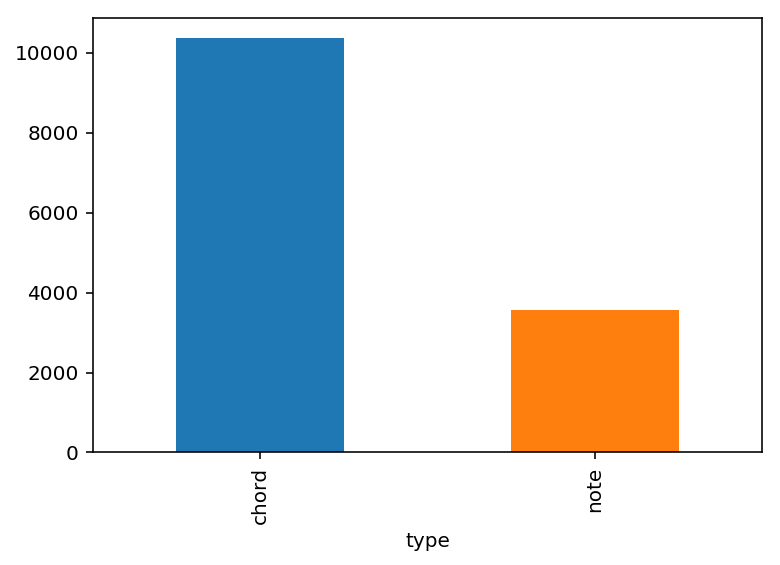

In [300]:
# number of chords vs number of notes
df.groupby('type').count()['name'].plot(kind='bar')

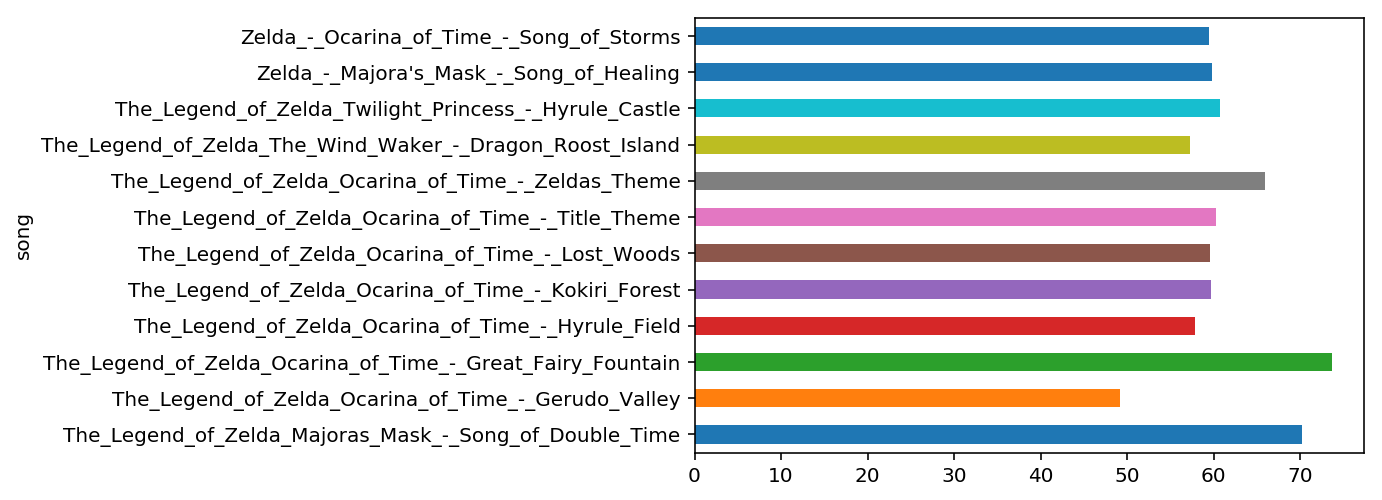

In [327]:
df.groupby('song').mean()['pitch_midi_value'].plot(kind='barh')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


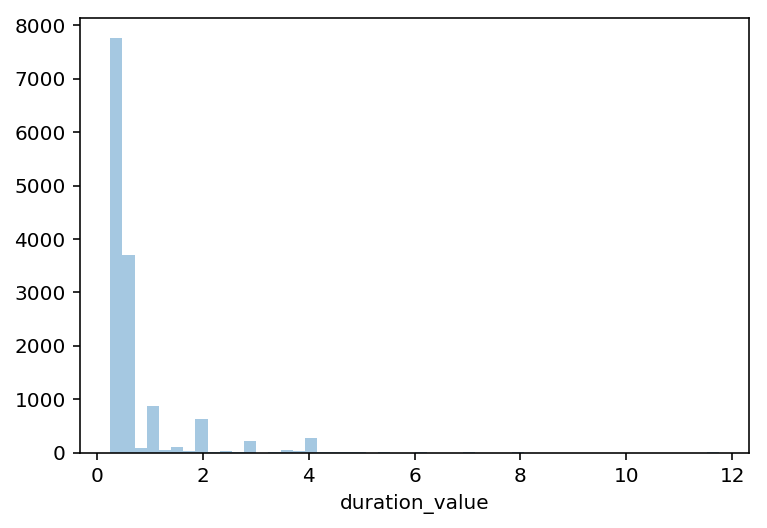

In [326]:
sns.distplot(df['duration_value'], kde=False);

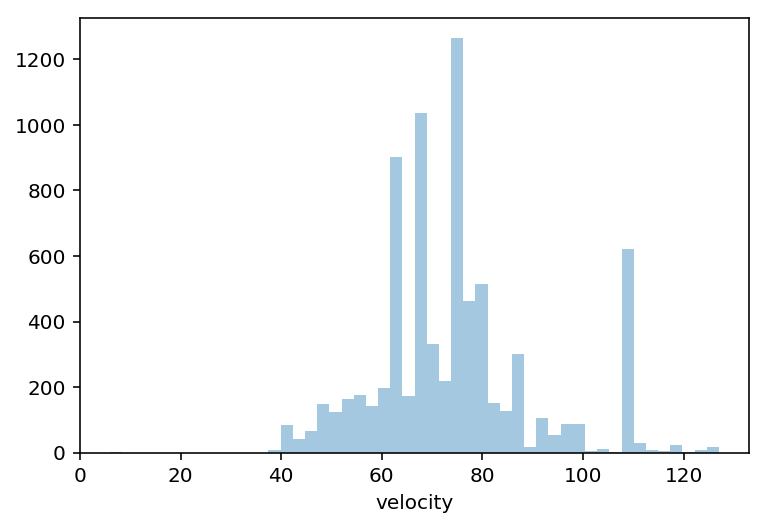

In [826]:
sns.distplot(df['velocity'], kde=False);

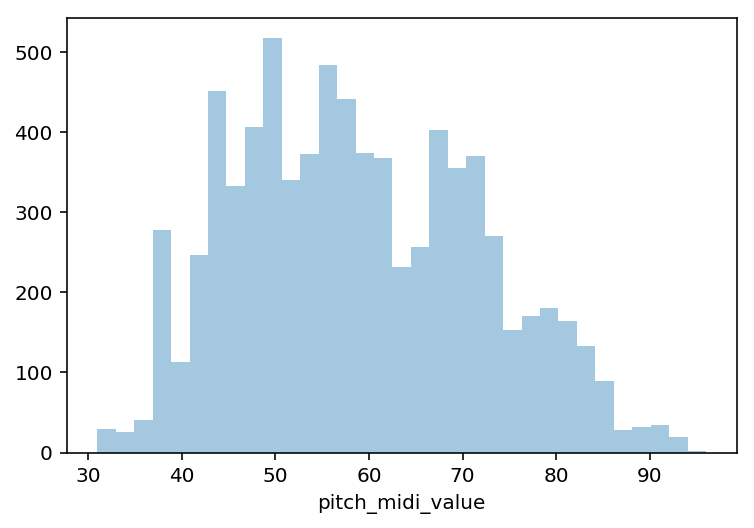

In [827]:
sns.distplot(df['pitch_midi_value'], kde=False);

<BarContainer object of 12 artists>

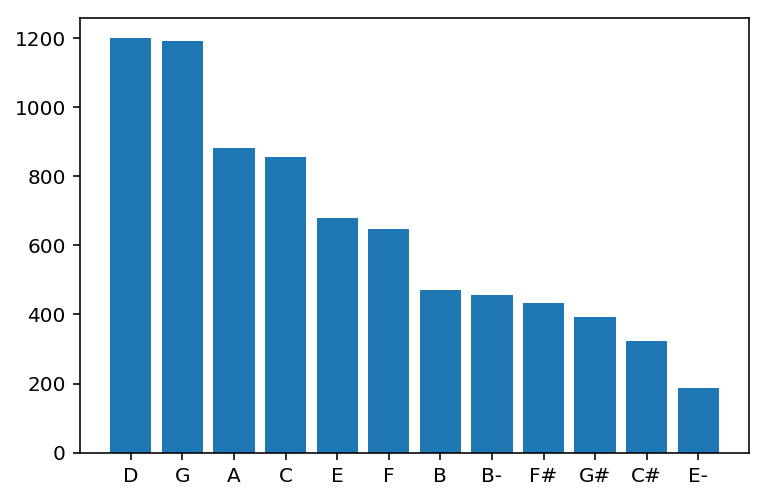

In [843]:
plt.bar(df['name'].value_counts().keys(), df['name'].value_counts().values)

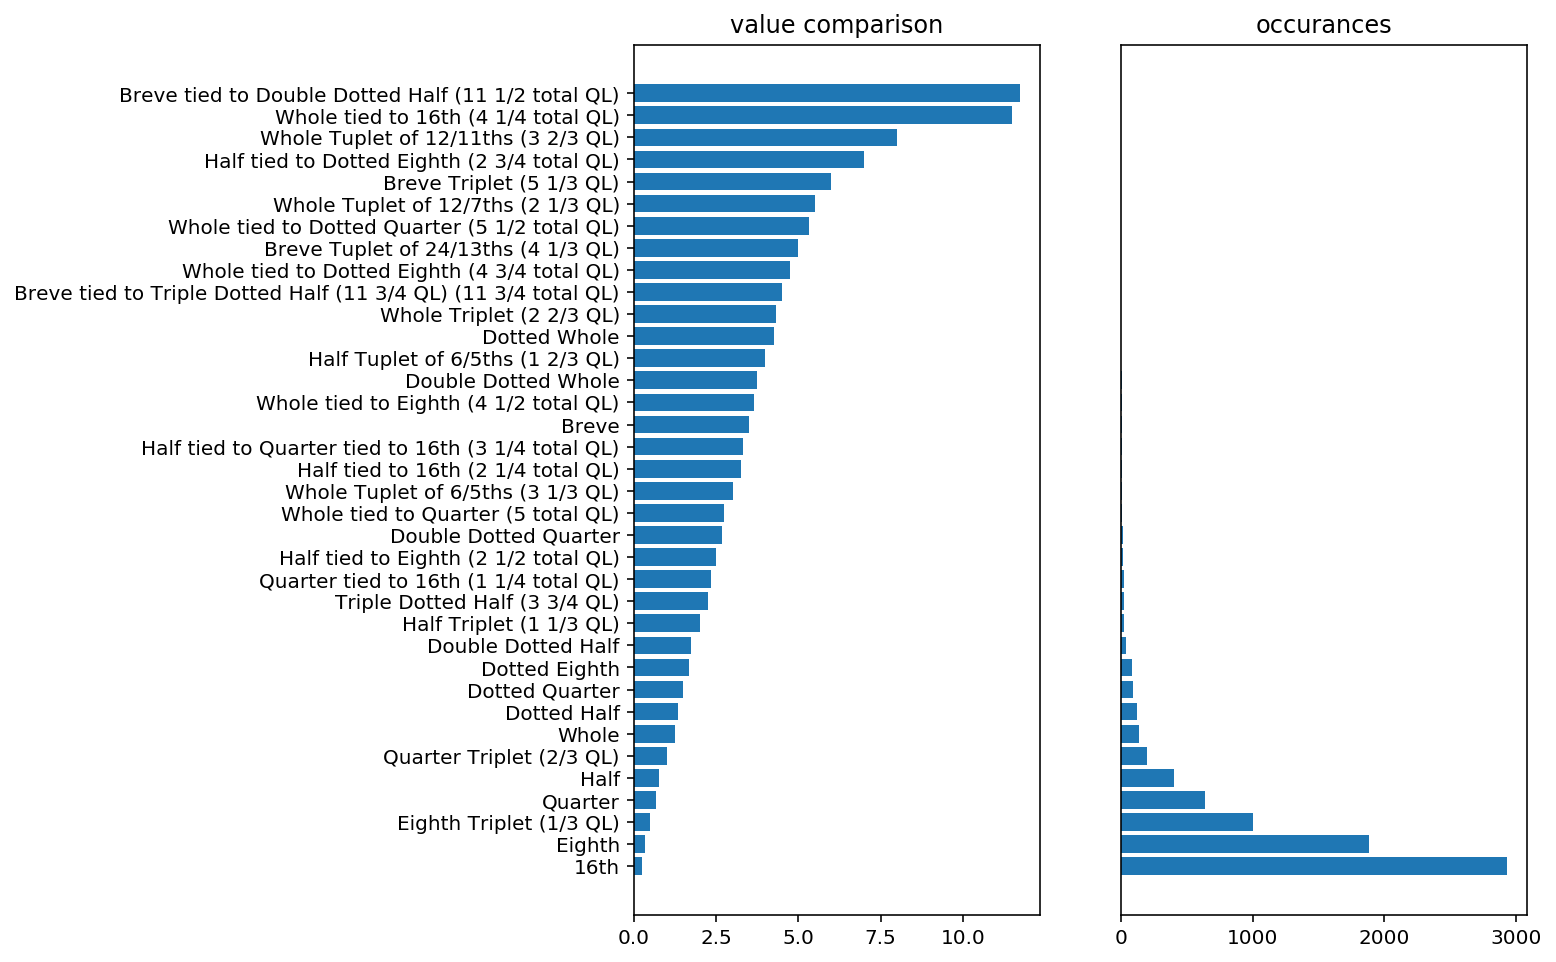

In [872]:
plt.figure(figsize=(8, 8))

ax1 = plt.subplot(121)
plt.barh(df.groupby('duration_name').max()['duration_value'].sort_values().keys(), df.groupby('duration_name').max()['duration_value'].sort_values().values)
plt.title('value comparison')

ax2 = plt.subplot(122, sharey=ax1)
plt.barh(df['duration_name'].value_counts().keys(), df['duration_name'].value_counts().values)
plt.title('occurances')
ax2.yaxis.set_visible(False)

In [873]:
df.head()

,song,stream,type,name,pitch_midi_value,velocity,duration_name,duration_value,prior_rest_time,start_time
0,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,69,46,Eighth,0.5,0.0,0.0
1,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,69,41,Eighth,0.5,0.0,0.5
2,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,D,62,41,Eighth,0.5,0.0,1.0
3,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,D,74,56,Eighth,0.5,0.0,1.5
4,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,F,65,44,Eighth,0.5,0.0,2.0


In [ ]:
df.groupby('song')

In [ ]:
df.groupby('song').mean()['pitch_midi_score'].plot()

In [245]:
df_chordless = df[df['type'] == 'note']

In [255]:
df_chordless.groupby('song').count()['type']

song
The_Legend_of_Zelda_Ocarina_of_Time_-_Gerudo_Valley            306
The_Legend_of_Zelda_Ocarina_of_Time_-_Great_Fairy_Fountain     203
The_Legend_of_Zelda_Ocarina_of_Time_-_Hyrule_Field            1102
The_Legend_of_Zelda_Ocarina_of_Time_-_Kokiri_Forest            607
The_Legend_of_Zelda_Ocarina_of_Time_-_Lost_Woods               212
The_Legend_of_Zelda_Ocarina_of_Time_-_Title_Theme              203
The_Legend_of_Zelda_Ocarina_of_Time_-_Zeldas_Theme             620
The_Legend_of_Zelda_The_Wind_Waker_-_Dragon_Roost_Island        97
The_Legend_of_Zelda_Twilight_Princess_-_Hyrule_Castle          293
Zelda_-_Majora's_Mask_-_Song_of_Healing                        187
Zelda_-_Ocarina_of_Time_-_Song_of_Storms                        55
Name: type, dtype: int64

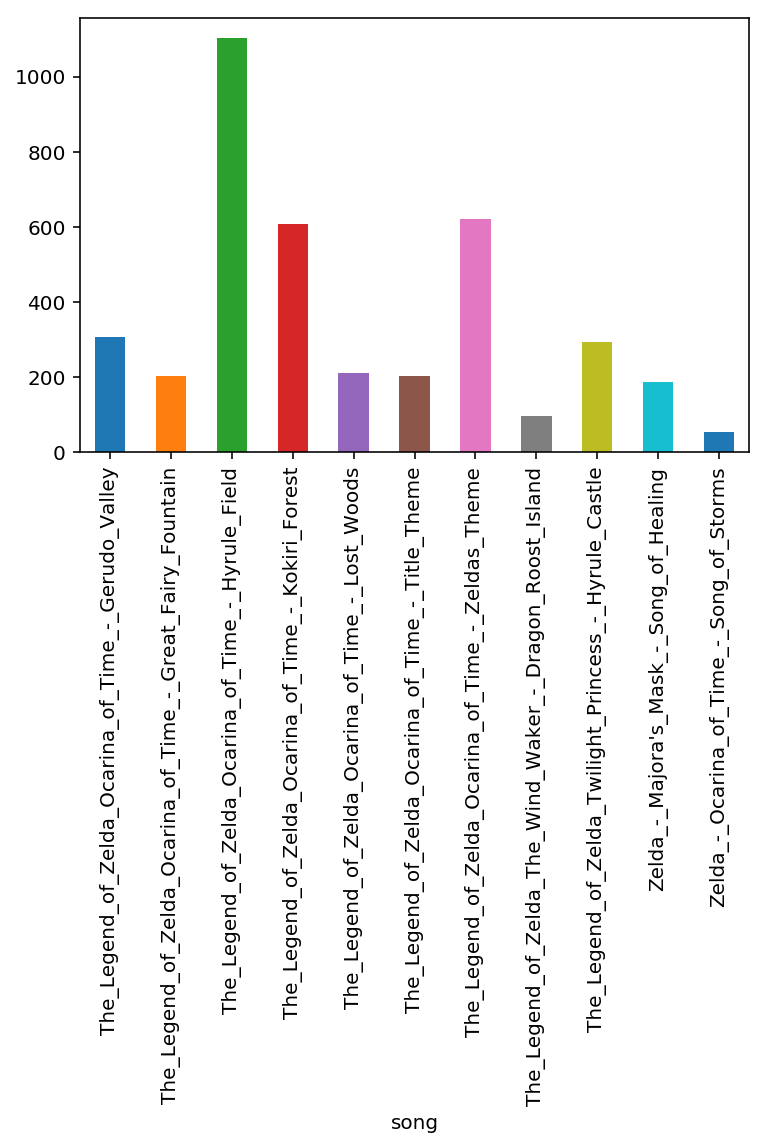

In [252]:
sns.barplot(x=df_chordless.groupby('song').count()['type'], y=df_chordless.groupby('song').count()['type'])#.plot(kind='bar')

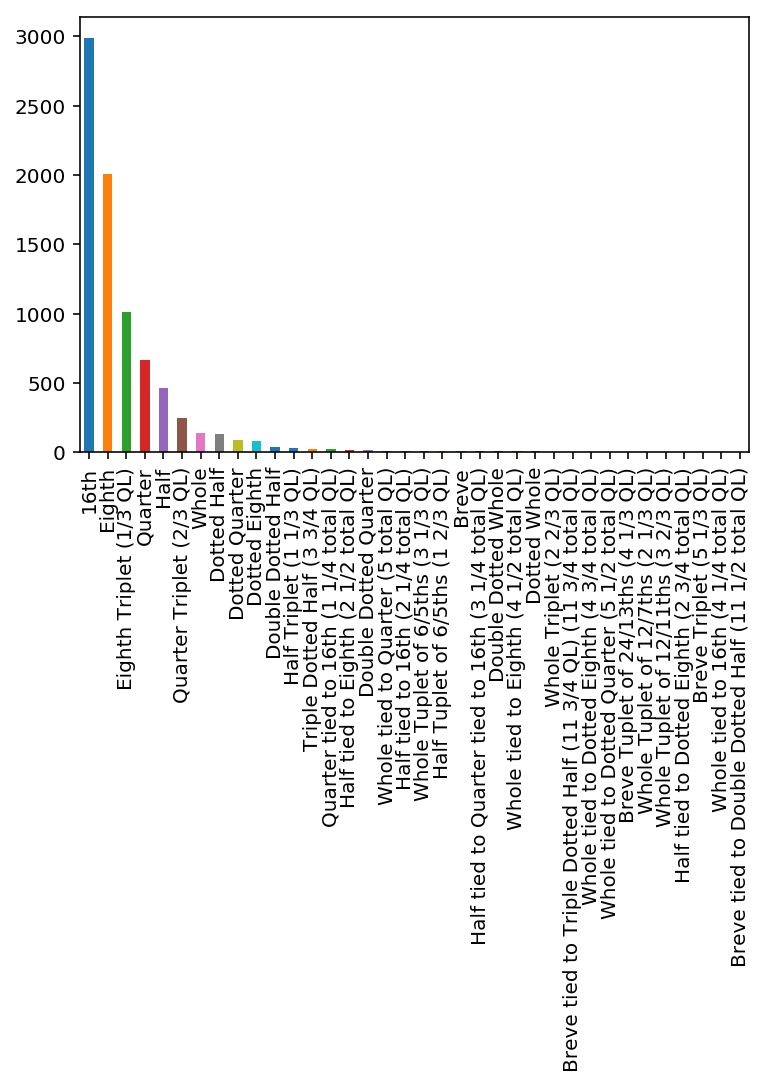

In [238]:
df['duration_name'].value_counts().plot(kind='bar')

In [216]:
df['duration_value'][df['duration_value'] == '1/3'].count()

1004

In [219]:
#df['duration_value'].map(lambda cell: (1/3) if cell == '1/3')

In [208]:
#df['duration_value'].map(lambda cell: float(cell))

In [205]:
df.describe()

,stream,prior_rest_time
count,8056.000000,8056.000000
mean,0.679618,0.636819
std,0.684681,3.466704
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.333333
max,5.000000,86.750000


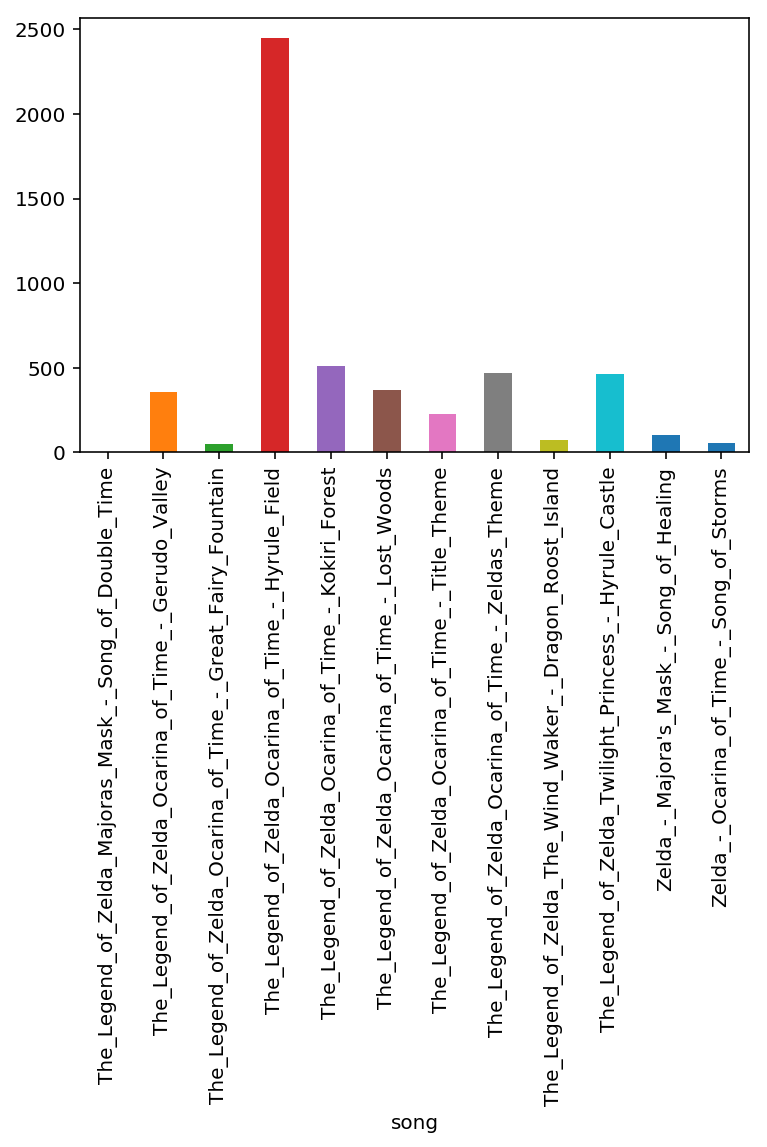

In [203]:
df.groupby('song').sum()['prior_rest_time'].plot(kind='bar')

In [ ]:
df_chord = df[df['type'] == 'chord']
for column in ['name', 'pitch_midi_value', 'velocity']:
    df_chord[column] = df_chord[column].map(lambda cell: tuple(cell))

df = df[df['type'] != 'chord'].append(df_chord).reset_index()

In [ ]:
df.tail()

In [ ]:
df.describe()

In [ ]:
df.groupby('name').mean()['duration_value'].plot(kind='barh');

In [ ]:
df.groupby('name').max()['duration_value'].plot(kind='barh');

In [ ]:
df.groupby('name').std()['duration_value'].plot(kind='barh');

In [ ]:
sns.distplot(df['prior_rest_time'], kde='False');

In [ ]:
sns.distplot([cell for cell in df['prior_rest_time'] if cell != 0], kde='False');

In [ ]:
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, cmap='viridis')

## Data Modeling

In [10]:
source_df = pd.read_csv('midi_dataframe')

In [11]:
source_df.head()

,song,stream,type,name,pitch_midi_value,velocity,duration_name,duration_value,prior_rest_time,start_time
0,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,69,46,Eighth,0.5,0.0,0.0
1,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,81,56,Eighth,0.5,0.0,0.0
2,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,69,41,Eighth,0.5,0.0,0.5
3,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,81,55,Eighth,0.5,0.0,0.5
4,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,D,62,41,Eighth,0.5,0.0,1.0


In [5]:
# setting random seed
np.random.seed(42)

In [13]:
def random_note_selection_from_chords(dataframe):
    list_of_positions = []
    counter = 0
    for i in range(dataframe.shape[0]):
        #print(i)
        try:
            if dataframe.loc[counter, 'type'] != 'chord':
                list_of_positions.append(counter)
                counter += 1
            else:
                chord_pairs = []
                for j in range(10):
                    try:
                        if ((dataframe.loc[counter+j, 'song'] != dataframe.loc[counter, 'song'])
                           | (dataframe.loc[counter+j, 'stream'] != dataframe.loc[counter, 'stream'])
                           | (dataframe.loc[counter+j, 'type'] != dataframe.loc[counter, 'type'])
                           | (dataframe.loc[counter+j, 'start_time'] != dataframe.loc[counter, 'start_time'])
                           | (dataframe.loc[counter+j, 'duration_value'] != dataframe.loc[counter, 'duration_value'])
                           ):
                            break
                        else:
                            chord_pairs.append(counter+j)                  
                    except: 
                        break

                list_of_positions.append(chord_pairs)
                counter += len(chord_pairs)
                #new_dataframe = new_dataframe.append(chord_pairs.sample(1, random_state=42))
        except:
            break
    
    list_of_randomly_chosen_positions = []
    for item in list_of_positions:
        if type(item) == list:
            list_of_randomly_chosen_positions.append(np.random.choice(item))
        else:
            list_of_randomly_chosen_positions.append(item)
    
    boolean = []
    for i in range(dataframe.shape[0]):
        if i in list_of_randomly_chosen_positions:
            boolean.append(True)
        else:
            boolean.append(False)
    
    return dataframe[boolean]

In [14]:
df = random_note_selection_from_chords(source_df).reset_index(drop=True)
df = df.sort_values(by=['song','start_time'])

In [15]:
df.head()

,song,stream,type,name,pitch_midi_value,velocity,duration_name,duration_value,prior_rest_time,start_time
0,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,69,46,Eighth,0.5,0.0,0.0
25,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,1,chord,A,57,55,Dotted Half,3.0,0.0,0.0
1,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,A,81,55,Eighth,0.5,0.0,0.5
2,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,D,62,41,Eighth,0.5,0.0,1.0
3,The_Legend_of_Zelda_Majoras_Mask_-_Song_of_Dou...,0,chord,D,62,42,Eighth,0.5,0.0,1.5


My next step is to train a neural network to this timeseries using LSTMs in Keras. NOTE: Code used here is mostly borrowed - credit goes to Dr. Brownlee. [2] 

In [21]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [1188]:
df['song'].value_counts().index[1]

'The_Legend_of_Zelda_Ocarina_of_Time_-_Gerudo_Valley'

### Training on Main Theme

In [290]:
df['song'].value_counts().index[3]

'The_Legend_of_Zelda_The_Wind_Waker_-_Dragon_Roost_Island'

In [291]:
Main_Theme = df[df['song'] == df['song'].value_counts().index[8]]

Train on 179 samples, validate on 77 samples
Epoch 1/50
 - 7s - loss: 59.1497 - val_loss: 60.0571
Epoch 2/50
 - 0s - loss: 57.3960 - val_loss: 58.1874
Epoch 3/50
 - 0s - loss: 55.5107 - val_loss: 56.1336
Epoch 4/50
 - 0s - loss: 53.4221 - val_loss: 53.8784
Epoch 5/50
 - 0s - loss: 51.1414 - val_loss: 51.4856
Epoch 6/50
 - 0s - loss: 48.7181 - val_loss: 48.9536
Epoch 7/50
 - 0s - loss: 46.1549 - val_loss: 46.3008
Epoch 8/50
 - 0s - loss: 43.4677 - val_loss: 43.5315
Epoch 9/50
 - 0s - loss: 40.6690 - val_loss: 40.6794
Epoch 10/50
 - 0s - loss: 37.7870 - val_loss: 37.7279
Epoch 11/50
 - 0s - loss: 34.8057 - val_loss: 34.6999
Epoch 12/50
 - 0s - loss: 31.7361 - val_loss: 31.5522
Epoch 13/50
 - 0s - loss: 28.5526 - val_loss: 28.2775
Epoch 14/50
 - 0s - loss: 25.2371 - val_loss: 24.9108
Epoch 15/50
 - 0s - loss: 21.9820 - val_loss: 21.6045
Epoch 16/50
 - 0s - loss: 18.8815 - val_loss: 18.7392
Epoch 17/50
 - 0s - loss: 16.3645 - val_loss: 16.4765
Epoch 18/50
 - 0s - loss: 14.2681 - val_loss: 

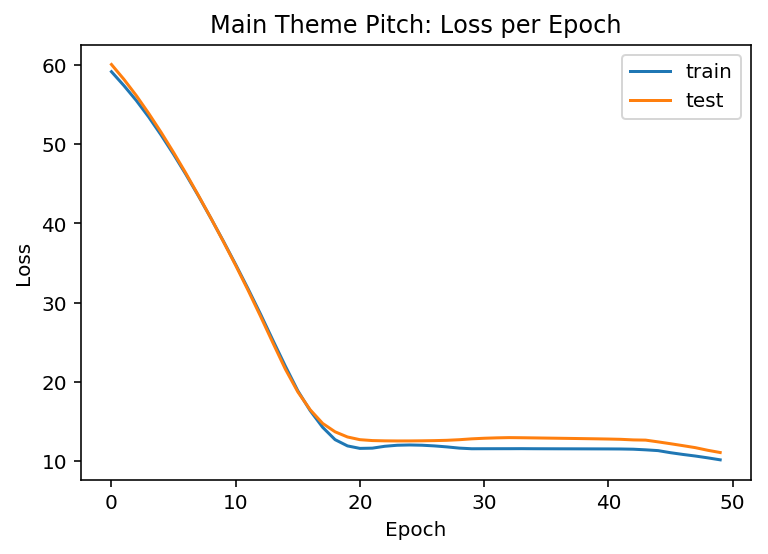

In [319]:
dataset = Main_Theme[['velocity', 'duration_value', 'pitch_midi_value']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
mt_test_y_p = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

mt_model_p = Sequential()
mt_model_p.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
mt_model_p.add(Dense(50))
mt_model_p.add(Dense(1))
mt_model_p.compile(loss='mae', optimizer='adam')
mt_history_p = mt_model_p.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(mt_history_p.history['loss'], label='train')
plt.plot(mt_history_p.history['val_loss'], label='test')
plt.legend()
plt.title('Main Theme Pitch: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [320]:
actual = list(mt_test_y_p)

predicted = []
for item in mt_model_p.predict(test_X):
    predicted.append(round(item[0]))

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,41.0,61.0
1,48.0,50.0
2,53.0,55.0
3,57.0,57.0
4,85.0,58.0


In [321]:
rmse = np.sqrt(mean_squared_error(predicted, actual))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 14.550


Train on 179 samples, validate on 77 samples
Epoch 1/50
 - 7s - loss: 60.6237 - val_loss: 60.9316
Epoch 2/50
 - 0s - loss: 58.6980 - val_loss: 58.8814
Epoch 3/50
 - 0s - loss: 56.6248 - val_loss: 56.7054
Epoch 4/50
 - 0s - loss: 54.3954 - val_loss: 54.3003
Epoch 5/50
 - 0s - loss: 51.9357 - val_loss: 51.6196
Epoch 6/50
 - 0s - loss: 49.1907 - val_loss: 48.6309
Epoch 7/50
 - 0s - loss: 46.1401 - val_loss: 45.3321
Epoch 8/50
 - 0s - loss: 42.7828 - val_loss: 41.7592
Epoch 9/50
 - 0s - loss: 39.1535 - val_loss: 37.9690
Epoch 10/50
 - 0s - loss: 35.3290 - val_loss: 34.1044
Epoch 11/50
 - 0s - loss: 31.4413 - val_loss: 30.2219
Epoch 12/50
 - 0s - loss: 27.5181 - val_loss: 26.2319
Epoch 13/50
 - 0s - loss: 23.4757 - val_loss: 22.1005
Epoch 14/50
 - 0s - loss: 19.3259 - val_loss: 17.8769
Epoch 15/50
 - 0s - loss: 15.0583 - val_loss: 13.5197
Epoch 16/50
 - 0s - loss: 10.9487 - val_loss: 9.1586
Epoch 17/50
 - 0s - loss: 7.3951 - val_loss: 4.9803
Epoch 18/50
 - 0s - loss: 4.1927 - val_loss: 1.69

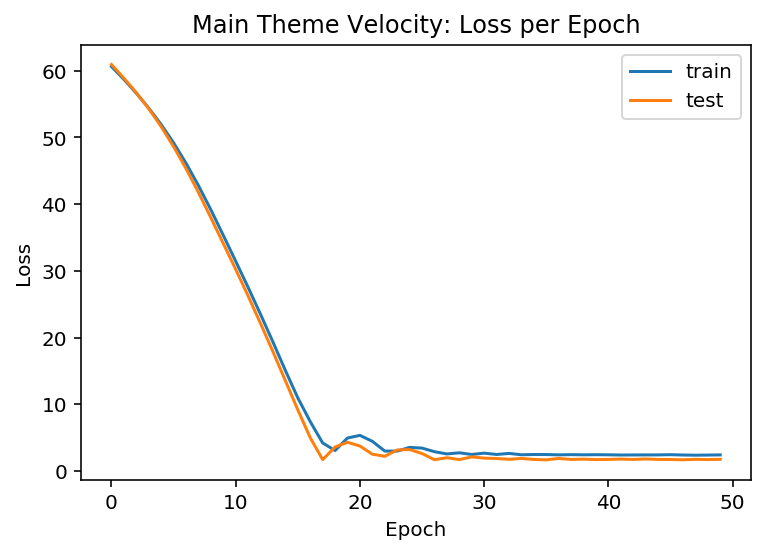

In [294]:
dataset = Main_Theme[['duration_value', 'pitch_midi_value', 'velocity']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
mt_test_y_v = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

mt_model_v = Sequential()
mt_model_v.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
mt_model_v.add(Dense(50))
mt_model_v.add(Dense(1))
mt_model_v.compile(loss='mae', optimizer='adam')
mt_history_v = mt_model_v.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(mt_history_v.history['loss'], label='train')
plt.plot(mt_history_v.history['val_loss'], label='test')
plt.legend()
plt.title('Main Theme Velocity: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [295]:
actual = list(mt_test_y_v)

predicted = []
for item in mt_model_v.predict(test_X):
    predicted.append(round(item[0]))

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,62.0,62.0
1,62.0,62.0
2,62.0,62.0
3,62.0,62.0
4,62.0,62.0


Train on 179 samples, validate on 77 samples
Epoch 1/50
 - 6s - loss: 0.6280 - val_loss: 0.6766
Epoch 2/50
 - 0s - loss: 0.6099 - val_loss: 0.6264
Epoch 3/50
 - 0s - loss: 0.5832 - val_loss: 0.6256
Epoch 4/50
 - 0s - loss: 0.5599 - val_loss: 0.6004
Epoch 5/50
 - 0s - loss: 0.5403 - val_loss: 0.6188
Epoch 6/50
 - 0s - loss: 0.5450 - val_loss: 0.5984
Epoch 7/50
 - 0s - loss: 0.5195 - val_loss: 0.5946
Epoch 8/50
 - 0s - loss: 0.5134 - val_loss: 0.5762
Epoch 9/50
 - 0s - loss: 0.4994 - val_loss: 0.5725
Epoch 10/50
 - 0s - loss: 0.5091 - val_loss: 0.5705
Epoch 11/50
 - 0s - loss: 0.4897 - val_loss: 0.5845
Epoch 12/50
 - 0s - loss: 0.4928 - val_loss: 0.5811
Epoch 13/50
 - 0s - loss: 0.4744 - val_loss: 0.5804
Epoch 14/50
 - 0s - loss: 0.4768 - val_loss: 0.5695
Epoch 15/50
 - 0s - loss: 0.4605 - val_loss: 0.5761
Epoch 16/50
 - 0s - loss: 0.4582 - val_loss: 0.5719
Epoch 17/50
 - 0s - loss: 0.4598 - val_loss: 0.5695
Epoch 18/50
 - 0s - loss: 0.4524 - val_loss: 0.5988
Epoch 19/50
 - 0s - loss: 0.

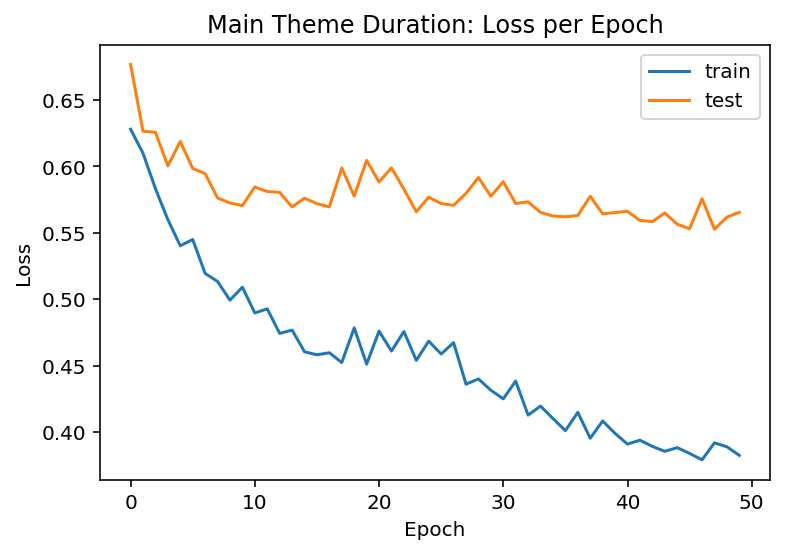

In [296]:
dataset = Main_Theme[['pitch_midi_value', 'velocity', 'duration_value']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
mt_test_y_d = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

mt_model_d = Sequential()
mt_model_d.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
mt_model_d.add(Dense(50))
mt_model_d.add(Dense(1))
mt_model_d.compile(loss='mae', optimizer='adam')
mt_history_d = mt_model_d.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(mt_history_d.history['loss'], label='train')
plt.plot(mt_history_d.history['val_loss'], label='test')
plt.legend()
plt.title('Main Theme Duration: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [297]:
actual = list(mt_test_y_d)

predicted = []
for item in mt_model_d.predict(test_X):
    predicted.append(item[0])

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,0.667,0.596926
1,0.500,0.430196
2,0.333,0.285979
3,0.333,0.251166
4,0.250,0.276633


In [ ]:
rmse = np.sqrt(mean_squared_error(predicted, actual))
print('Test RMSE: %.3f' % rmse)

### Training on Zelda Theme

In [220]:
df['song'].value_counts().index[3]

'The_Legend_of_Zelda_The_Wind_Waker_-_Dragon_Roost_Island'

In [221]:
Zelda_Theme = df[df['song'] == df['song'].value_counts().index[6]]

Train on 234 samples, validate on 101 samples
Epoch 1/50
 - 4s - loss: 64.5766 - val_loss: 61.0555
Epoch 2/50
 - 0s - loss: 62.1123 - val_loss: 58.5158
Epoch 3/50
 - 0s - loss: 59.5099 - val_loss: 55.7274
Epoch 4/50
 - 0s - loss: 56.6740 - val_loss: 52.7323
Epoch 5/50
 - 0s - loss: 53.6288 - val_loss: 49.5671
Epoch 6/50
 - 0s - loss: 50.4362 - val_loss: 46.2988
Epoch 7/50
 - 0s - loss: 47.1270 - val_loss: 42.8709
Epoch 8/50
 - 0s - loss: 43.6401 - val_loss: 39.2895
Epoch 9/50
 - 0s - loss: 40.0228 - val_loss: 35.5912
Epoch 10/50
 - 0s - loss: 36.2644 - val_loss: 31.6541
Epoch 11/50
 - 0s - loss: 32.2628 - val_loss: 27.5152
Epoch 12/50
 - 0s - loss: 28.0677 - val_loss: 23.1623
Epoch 13/50
 - 0s - loss: 23.6601 - val_loss: 18.6620
Epoch 14/50
 - 0s - loss: 19.2170 - val_loss: 14.5308
Epoch 15/50
 - 0s - loss: 15.3796 - val_loss: 11.1620
Epoch 16/50
 - 0s - loss: 12.0908 - val_loss: 8.8407
Epoch 17/50
 - 0s - loss: 9.7929 - val_loss: 8.3896
Epoch 18/50
 - 0s - loss: 8.7942 - val_loss: 8.8

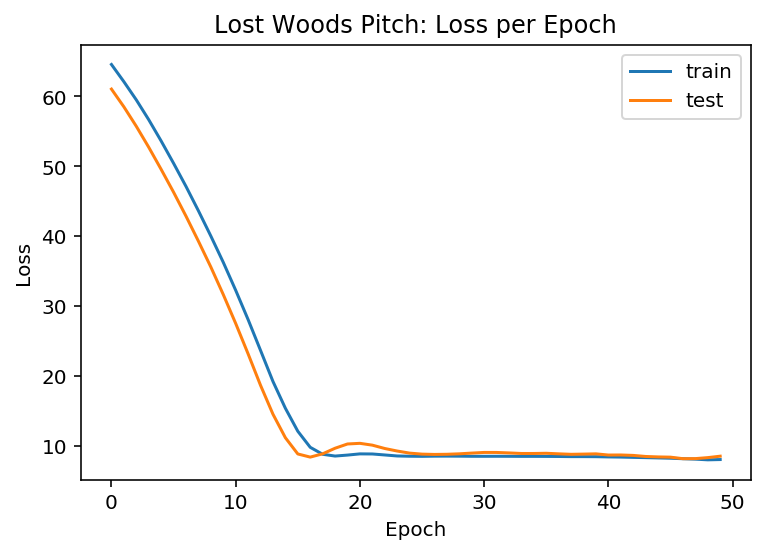

In [222]:
dataset = Zelda_Theme[['velocity', 'duration_value', 'pitch_midi_value']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
zt_test_y_p = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

zt_model_p = Sequential()
zt_model_p.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
zt_model_p.add(Dense(50))
zt_model_p.add(Dense(1))
zt_model_p.compile(loss='mae', optimizer='adam')
zt_history_p = zt_model_p.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(zt_history_p.history['loss'], label='train')
plt.plot(zt_history_p.history['val_loss'], label='test')
plt.legend()
plt.title('Zelda Theme Pitch: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [223]:
actual = list(zt_test_y_p)

predicted = []
for item in zt_model_p.predict(test_X):
    predicted.append(round(item[0]))

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,66.0,68.0
1,71.0,70.0
2,48.0,69.0
3,55.0,64.0
4,64.0,66.0


Train on 234 samples, validate on 101 samples
Epoch 1/50
 - 4s - loss: 63.1982 - val_loss: 61.3847
Epoch 2/50
 - 0s - loss: 60.7667 - val_loss: 58.9923
Epoch 3/50
 - 0s - loss: 58.3399 - val_loss: 56.4371
Epoch 4/50
 - 0s - loss: 55.6944 - val_loss: 53.5101
Epoch 5/50
 - 0s - loss: 52.6398 - val_loss: 50.1519
Epoch 6/50
 - 0s - loss: 49.1515 - val_loss: 46.4550
Epoch 7/50
 - 0s - loss: 45.3926 - val_loss: 42.5972
Epoch 8/50
 - 0s - loss: 41.5050 - val_loss: 38.6115
Epoch 9/50
 - 0s - loss: 37.5018 - val_loss: 34.5118
Epoch 10/50
 - 0s - loss: 33.3876 - val_loss: 30.2811
Epoch 11/50
 - 0s - loss: 29.1288 - val_loss: 25.8864
Epoch 12/50
 - 0s - loss: 24.6688 - val_loss: 21.2413
Epoch 13/50
 - 0s - loss: 19.9382 - val_loss: 16.3017
Epoch 14/50
 - 0s - loss: 14.9099 - val_loss: 11.0896
Epoch 15/50
 - 0s - loss: 9.6490 - val_loss: 6.0063
Epoch 16/50
 - 0s - loss: 5.0871 - val_loss: 3.6099
Epoch 17/50
 - 0s - loss: 4.1533 - val_loss: 5.0954
Epoch 18/50
 - 0s - loss: 4.9778 - val_loss: 5.2883

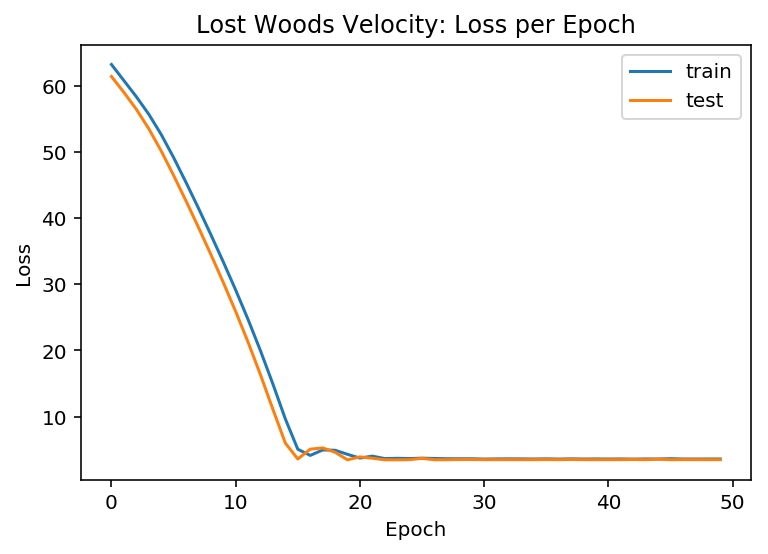

In [224]:
dataset = Zelda_Theme[['duration_value', 'pitch_midi_value', 'velocity']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
zt_test_y_v = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

zt_model_v = Sequential()
zt_model_v.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
zt_model_v.add(Dense(50))
zt_model_v.add(Dense(1))
zt_model_v.compile(loss='mae', optimizer='adam')
zt_history_v = zt_model_v.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(zt_history_v.history['loss'], label='train')
plt.plot(zt_history_v.history['val_loss'], label='test')
plt.legend()
plt.title('Zelda Theme Velocity: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [225]:
actual = list(zt_test_y_v)

predicted = []
for item in zt_model_v.predict(test_X):
    predicted.append(round(item[0]))

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,57.0,62.0
1,62.0,62.0
2,62.0,62.0
3,62.0,62.0
4,57.0,62.0


Train on 234 samples, validate on 101 samples
Epoch 1/50
 - 3s - loss: 0.7090 - val_loss: 0.8018
Epoch 2/50
 - 0s - loss: 0.7907 - val_loss: 0.5803
Epoch 3/50
 - 0s - loss: 0.5700 - val_loss: 0.6002
Epoch 4/50
 - 0s - loss: 0.6115 - val_loss: 0.4730
Epoch 5/50
 - 0s - loss: 0.5534 - val_loss: 0.5104
Epoch 6/50
 - 0s - loss: 0.5536 - val_loss: 0.4432
Epoch 7/50
 - 0s - loss: 0.5196 - val_loss: 0.4292
Epoch 8/50
 - 0s - loss: 0.5149 - val_loss: 0.4437
Epoch 9/50
 - 0s - loss: 0.5138 - val_loss: 0.4169
Epoch 10/50
 - 0s - loss: 0.4975 - val_loss: 0.4145
Epoch 11/50
 - 0s - loss: 0.4955 - val_loss: 0.4113
Epoch 12/50
 - 0s - loss: 0.4784 - val_loss: 0.4088
Epoch 13/50
 - 0s - loss: 0.4757 - val_loss: 0.4066
Epoch 14/50
 - 0s - loss: 0.4675 - val_loss: 0.4137
Epoch 15/50
 - 0s - loss: 0.4676 - val_loss: 0.4120
Epoch 16/50
 - 0s - loss: 0.4601 - val_loss: 0.4135
Epoch 17/50
 - 0s - loss: 0.4626 - val_loss: 0.4115
Epoch 18/50
 - 0s - loss: 0.4561 - val_loss: 0.4094
Epoch 19/50
 - 0s - loss: 0

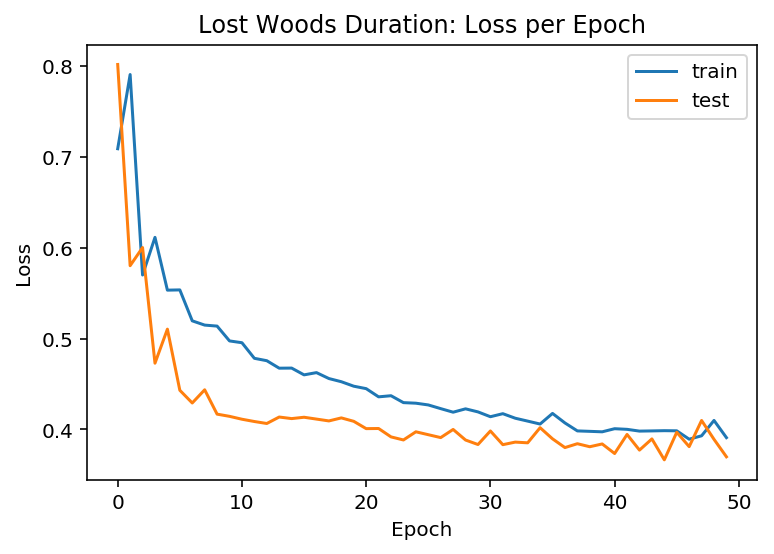

In [226]:
dataset = Zelda_Theme[['pitch_midi_value', 'velocity', 'duration_value']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
zt_test_y_d = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

zt_model_d = Sequential()
zt_model_d.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
zt_model_d.add(Dense(50))
zt_model_d.add(Dense(1))
zt_model_d.compile(loss='mae', optimizer='adam')
zt_history_d = zt_model_d.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(zt_history_d.history['loss'], label='train')
plt.plot(zt_history_d.history['val_loss'], label='test')
plt.legend()
plt.title('Zelda Theme Duration: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [227]:
actual = list(zt_test_y_d)

predicted = []
for item in zt_model_d.predict(test_X):
    predicted.append(item[0])

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,2.000,1.523494
1,2.000,0.766018
2,0.667,0.684277
3,0.500,0.418970
4,2.000,1.523746


### Training on Lost Woods

In [228]:
Lost_Woods = df[df['song'] == df['song'].value_counts().index[4]]

Train on 295 samples, validate on 126 samples
Epoch 1/50
 - 3s - loss: 59.2415 - val_loss: 55.5752
Epoch 2/50
 - 0s - loss: 56.1762 - val_loss: 52.3863
Epoch 3/50
 - 0s - loss: 52.8490 - val_loss: 48.7977
Epoch 4/50
 - 0s - loss: 49.1183 - val_loss: 44.8031
Epoch 5/50
 - 0s - loss: 44.9980 - val_loss: 40.3998
Epoch 6/50
 - 0s - loss: 40.5078 - val_loss: 35.8148
Epoch 7/50
 - 0s - loss: 35.9156 - val_loss: 31.1280
Epoch 8/50
 - 0s - loss: 31.1739 - val_loss: 26.1890
Epoch 9/50
 - 0s - loss: 26.1462 - val_loss: 20.8985
Epoch 10/50
 - 0s - loss: 20.7339 - val_loss: 15.2365
Epoch 11/50
 - 0s - loss: 15.0196 - val_loss: 10.0466
Epoch 12/50
 - 0s - loss: 9.6527 - val_loss: 7.3001
Epoch 13/50
 - 0s - loss: 6.6274 - val_loss: 7.6736
Epoch 14/50
 - 0s - loss: 6.7299 - val_loss: 8.6731
Epoch 15/50
 - 0s - loss: 7.3868 - val_loss: 8.8729
Epoch 16/50
 - 0s - loss: 7.4104 - val_loss: 8.4982
Epoch 17/50
 - 0s - loss: 7.0321 - val_loss: 7.8826
Epoch 18/50
 - 0s - loss: 6.6025 - val_loss: 7.3732
Epoch

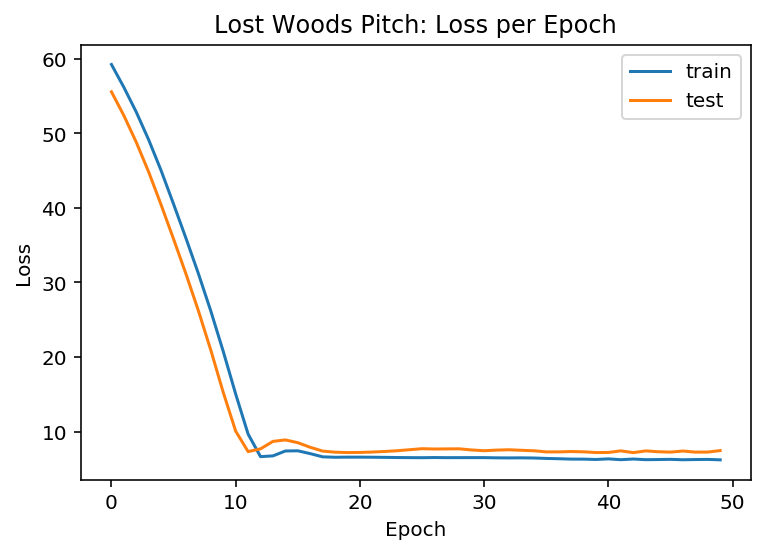

In [229]:
dataset = Lost_Woods[['velocity', 'duration_value', 'pitch_midi_value']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
lw_test_y_p = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

lw_model_p = Sequential()
lw_model_p.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
lw_model_p.add(Dense(50))
lw_model_p.add(Dense(1))
lw_model_p.compile(loss='mae', optimizer='adam')
lw_history_p = lw_model_p.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(lw_history_p.history['loss'], label='train')
plt.plot(lw_history_p.history['val_loss'], label='test')
plt.legend()
plt.title('Lost Woods Pitch: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [230]:
actual = list(lw_test_y_p)

predicted = []
for item in lw_model_p.predict(test_X):
    predicted.append(round(item[0]))

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,48.0,61.0
1,64.0,58.0
2,57.0,60.0
3,50.0,60.0
4,53.0,56.0


Train on 295 samples, validate on 126 samples
Epoch 1/50
 - 4s - loss: 72.0662 - val_loss: 69.4496
Epoch 2/50
 - 0s - loss: 69.4811 - val_loss: 66.7336
Epoch 3/50
 - 0s - loss: 66.6512 - val_loss: 63.6190
Epoch 4/50
 - 0s - loss: 63.3240 - val_loss: 59.8035
Epoch 5/50
 - 0s - loss: 59.2411 - val_loss: 55.3128
Epoch 6/50
 - 0s - loss: 54.6638 - val_loss: 50.6475
Epoch 7/50
 - 0s - loss: 50.0046 - val_loss: 45.9474
Epoch 8/50
 - 0s - loss: 45.2979 - val_loss: 41.0512
Epoch 9/50
 - 0s - loss: 40.3132 - val_loss: 35.8210
Epoch 10/50
 - 0s - loss: 34.9689 - val_loss: 30.2055
Epoch 11/50
 - 0s - loss: 29.2453 - val_loss: 24.2269
Epoch 12/50
 - 0s - loss: 23.1385 - val_loss: 17.8376
Epoch 13/50
 - 0s - loss: 16.6285 - val_loss: 11.0524
Epoch 14/50
 - 0s - loss: 10.0060 - val_loss: 6.9484
Epoch 15/50
 - 0s - loss: 5.9086 - val_loss: 5.3389
Epoch 16/50
 - 0s - loss: 4.6824 - val_loss: 6.4422
Epoch 17/50
 - 0s - loss: 5.7795 - val_loss: 6.0712
Epoch 18/50
 - 0s - loss: 4.9191 - val_loss: 5.1575


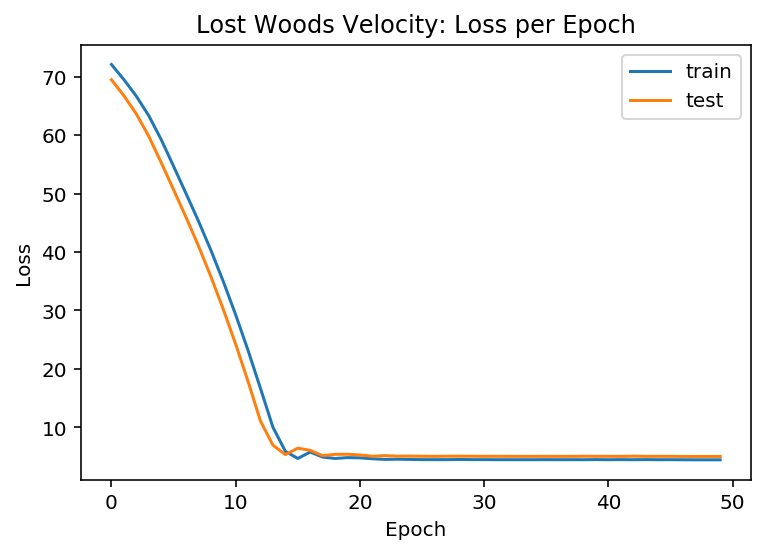

In [231]:
dataset = Lost_Woods[['duration_value', 'pitch_midi_value', 'velocity']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
lw_test_y_v = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

lw_model_v = Sequential()
lw_model_v.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
lw_model_v.add(Dense(50))
lw_model_v.add(Dense(1))
lw_model_v.compile(loss='mae', optimizer='adam')
lw_history_v = lw_model_v.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(lw_history_v.history['loss'], label='train')
plt.plot(lw_history_v.history['val_loss'], label='test')
plt.legend()
plt.title('Lost Woods Velocity: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [232]:
actual = list(lw_test_y_v)

predicted = []
for item in lw_model_v.predict(test_X):
    predicted.append(round(item[0]))

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,75.0,75.0
1,70.0,75.0
2,76.0,75.0
3,75.0,75.0
4,62.0,75.0


Train on 295 samples, validate on 126 samples
Epoch 1/50
 - 4s - loss: 0.3912 - val_loss: 0.4616
Epoch 2/50
 - 0s - loss: 0.3579 - val_loss: 0.2539
Epoch 3/50
 - 0s - loss: 0.3319 - val_loss: 0.3420
Epoch 4/50
 - 0s - loss: 0.2916 - val_loss: 0.2953
Epoch 5/50
 - 0s - loss: 0.2703 - val_loss: 0.2741
Epoch 6/50
 - 0s - loss: 0.2744 - val_loss: 0.2529
Epoch 7/50
 - 0s - loss: 0.2575 - val_loss: 0.2405
Epoch 8/50
 - 0s - loss: 0.2482 - val_loss: 0.2471
Epoch 9/50
 - 0s - loss: 0.2474 - val_loss: 0.2451
Epoch 10/50
 - 0s - loss: 0.2447 - val_loss: 0.2212
Epoch 11/50
 - 0s - loss: 0.2335 - val_loss: 0.2122
Epoch 12/50
 - 0s - loss: 0.2323 - val_loss: 0.2579
Epoch 13/50
 - 0s - loss: 0.2506 - val_loss: 0.2118
Epoch 14/50
 - 0s - loss: 0.2326 - val_loss: 0.2312
Epoch 15/50
 - 0s - loss: 0.2328 - val_loss: 0.2183
Epoch 16/50
 - 0s - loss: 0.2297 - val_loss: 0.2095
Epoch 17/50
 - 0s - loss: 0.2227 - val_loss: 0.2091
Epoch 18/50
 - 0s - loss: 0.2211 - val_loss: 0.2064
Epoch 19/50
 - 0s - loss: 0

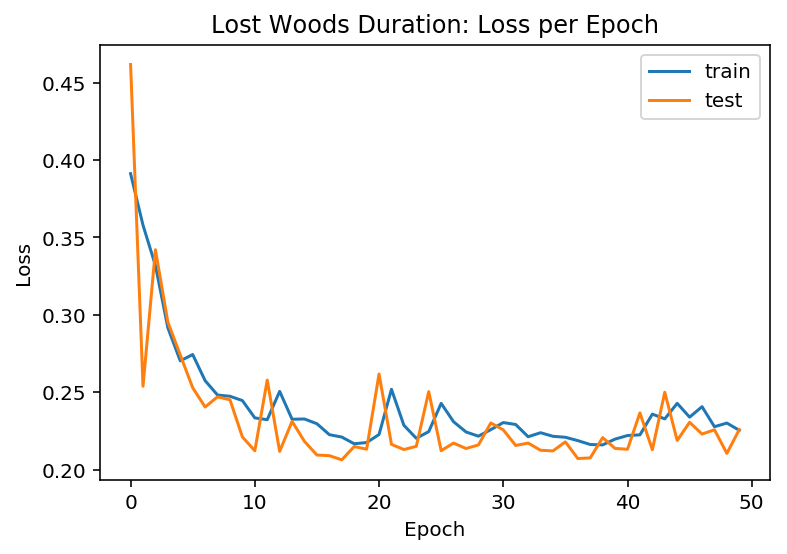

In [233]:
dataset = Lost_Woods[['pitch_midi_value', 'velocity', 'duration_value']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
lw_test_y_d = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

lw_model_d = Sequential()
lw_model_d.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
lw_model_d.add(Dense(50))
lw_model_d.add(Dense(1))
lw_model_d.compile(loss='mae', optimizer='adam')
lw_history_d = lw_model_d.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(lw_history_d.history['loss'], label='train')
plt.plot(lw_history_d.history['val_loss'], label='test')
plt.legend()
plt.title('Lost Woods Duration: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [234]:
actual = list(lw_test_y_d)

predicted = []
for item in lw_model_d.predict(test_X):
    predicted.append(item[0])

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,0.50,0.383302
1,0.25,0.200591
2,0.25,0.258465
3,0.50,0.372677
4,0.25,0.185245


In [235]:
(comparison['predicted'].min(), comparison['predicted'].max()), (comparison['actual'].min(), comparison['actual'].max())

((0.16391445696353912, 0.5992714762687683), (0.25, 6.0))

In [236]:
rmse = np.sqrt(mean_squared_error(predicted, actual))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.691


### Training on Song of Storms

In [237]:
Song_of_Storms = df[df['song'] == df['song'].value_counts().index[10]]

Train on 61 samples, validate on 26 samples
Epoch 1/50
 - 4s - loss: 62.4598 - val_loss: 59.8329
Epoch 2/50
 - 0s - loss: 61.8870 - val_loss: 59.2672
Epoch 3/50
 - 0s - loss: 61.3223 - val_loss: 58.7589
Epoch 4/50
 - 0s - loss: 60.8139 - val_loss: 58.2029
Epoch 5/50
 - 0s - loss: 60.2571 - val_loss: 57.6453
Epoch 6/50
 - 0s - loss: 59.7006 - val_loss: 57.0839
Epoch 7/50
 - 0s - loss: 59.1408 - val_loss: 56.5184
Epoch 8/50
 - 0s - loss: 58.5765 - val_loss: 55.9491
Epoch 9/50
 - 0s - loss: 58.0084 - val_loss: 55.3799
Epoch 10/50
 - 0s - loss: 57.4413 - val_loss: 54.8015
Epoch 11/50
 - 0s - loss: 56.8642 - val_loss: 54.2198
Epoch 12/50
 - 0s - loss: 56.2820 - val_loss: 53.6328
Epoch 13/50
 - 0s - loss: 55.6930 - val_loss: 53.0353
Epoch 14/50
 - 0s - loss: 55.0945 - val_loss: 52.4244
Epoch 15/50
 - 0s - loss: 54.4841 - val_loss: 51.8019
Epoch 16/50
 - 0s - loss: 53.8610 - val_loss: 51.1677
Epoch 17/50
 - 0s - loss: 53.2251 - val_loss: 50.5195
Epoch 18/50
 - 0s - loss: 52.5751 - val_loss: 4

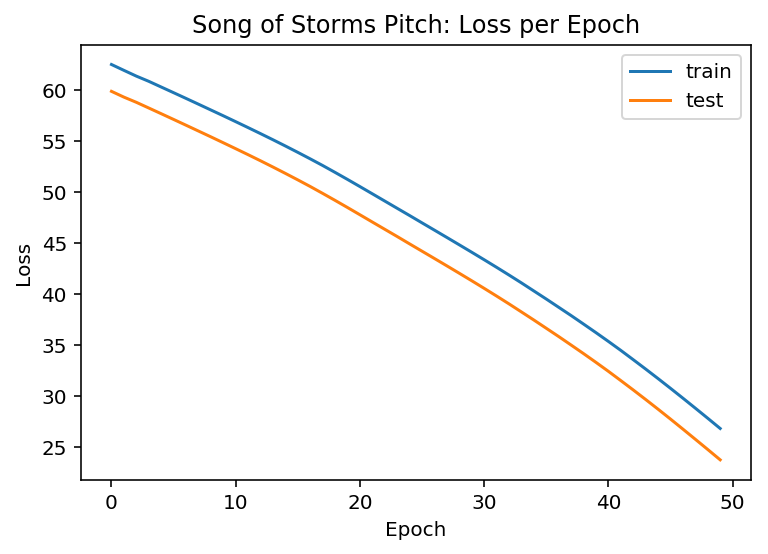

In [238]:
dataset = Song_of_Storms[['velocity', 'duration_value', 'pitch_midi_value']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
ss_test_y_p = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

ss_model_p = Sequential()
ss_model_p.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
ss_model_p.add(Dense(50))
ss_model_p.add(Dense(1))
ss_model_p.compile(loss='mae', optimizer='adam')
ss_history_p = ss_model_p.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(ss_history_p.history['loss'], label='train')
plt.plot(ss_history_p.history['val_loss'], label='test')
plt.legend()
plt.title('Song of Storms Pitch: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [239]:
actual = list(ss_test_y_p)

predicted = []
for item in ss_model_p.predict(test_X):
    predicted.append(round(item[0]))

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,77.0,35.0
1,76.0,35.0
2,52.0,35.0
3,72.0,35.0
4,59.0,35.0


Train on 61 samples, validate on 26 samples
Epoch 1/50
 - 4s - loss: 75.9873 - val_loss: 73.1388
Epoch 2/50
 - 0s - loss: 75.3534 - val_loss: 72.5032
Epoch 3/50
 - 0s - loss: 74.7187 - val_loss: 71.8677
Epoch 4/50
 - 0s - loss: 74.0830 - val_loss: 71.2315
Epoch 5/50
 - 0s - loss: 73.4465 - val_loss: 70.5911
Epoch 6/50
 - 0s - loss: 72.8072 - val_loss: 69.9464
Epoch 7/50
 - 0s - loss: 72.1640 - val_loss: 69.2951
Epoch 8/50
 - 0s - loss: 71.5141 - val_loss: 68.6329
Epoch 9/50
 - 0s - loss: 70.8520 - val_loss: 67.9553
Epoch 10/50
 - 0s - loss: 70.1733 - val_loss: 67.2609
Epoch 11/50
 - 0s - loss: 69.4750 - val_loss: 66.5490
Epoch 12/50
 - 0s - loss: 68.7581 - val_loss: 65.8160
Epoch 13/50
 - 0s - loss: 68.0204 - val_loss: 65.0624
Epoch 14/50
 - 0s - loss: 67.2636 - val_loss: 64.2876
Epoch 15/50
 - 0s - loss: 66.4863 - val_loss: 63.4925
Epoch 16/50
 - 0s - loss: 65.6888 - val_loss: 62.6813
Epoch 17/50
 - 0s - loss: 64.8749 - val_loss: 61.8504
Epoch 18/50
 - 0s - loss: 64.0382 - val_loss: 6

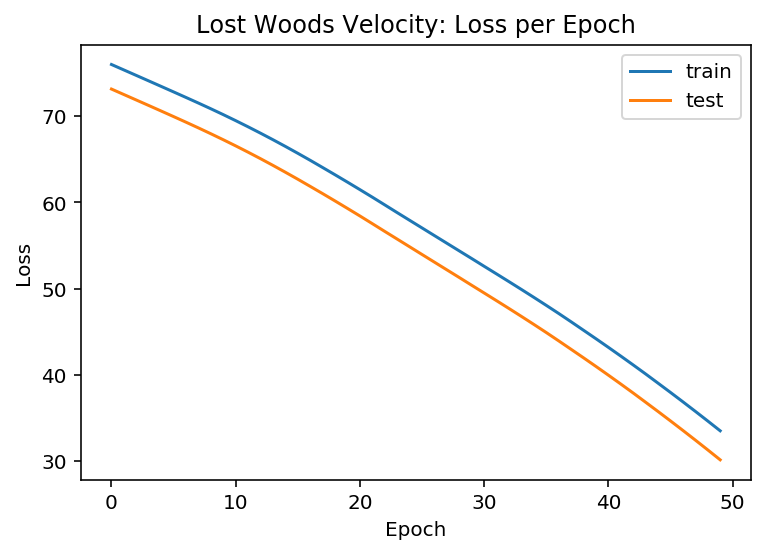

In [240]:
dataset = Song_of_Storms[['duration_value', 'pitch_midi_value', 'velocity']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
ss_test_y_v = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

ss_model_v = Sequential()
ss_model_v.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
ss_model_v.add(Dense(50))
ss_model_v.add(Dense(1))
ss_model_v.compile(loss='mae', optimizer='adam')
ss_history_v = ss_model_v.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(ss_history_v.history['loss'], label='train')
plt.plot(ss_history_v.history['val_loss'], label='test')
plt.legend()
plt.title('Song of Storms Velocity: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [241]:
actual = list(ss_test_y_v)

predicted = []
for item in ss_model_v.predict(test_X):
    predicted.append(round(item[0]))

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,81.0,44.0
1,76.0,44.0
2,69.0,44.0
3,66.0,44.0
4,67.0,44.0


Train on 61 samples, validate on 26 samples
Epoch 1/50
 - 4s - loss: 0.8393 - val_loss: 0.8300
Epoch 2/50
 - 0s - loss: 0.8360 - val_loss: 0.8197
Epoch 3/50
 - 0s - loss: 0.8383 - val_loss: 0.7907
Epoch 4/50
 - 0s - loss: 0.8039 - val_loss: 0.7608
Epoch 5/50
 - 0s - loss: 0.7446 - val_loss: 0.7835
Epoch 6/50
 - 0s - loss: 0.7203 - val_loss: 0.7954
Epoch 7/50
 - 0s - loss: 0.7139 - val_loss: 0.7316
Epoch 8/50
 - 0s - loss: 0.6749 - val_loss: 0.6940
Epoch 9/50
 - 0s - loss: 0.6541 - val_loss: 0.6709
Epoch 10/50
 - 0s - loss: 0.6405 - val_loss: 0.6552
Epoch 11/50
 - 0s - loss: 0.6200 - val_loss: 0.6501
Epoch 12/50
 - 0s - loss: 0.5936 - val_loss: 0.6543
Epoch 13/50
 - 0s - loss: 0.5934 - val_loss: 0.6307
Epoch 14/50
 - 0s - loss: 0.5689 - val_loss: 0.5965
Epoch 15/50
 - 0s - loss: 0.5571 - val_loss: 0.5708
Epoch 16/50
 - 0s - loss: 0.5501 - val_loss: 0.5526
Epoch 17/50
 - 0s - loss: 0.5329 - val_loss: 0.5414
Epoch 18/50
 - 0s - loss: 0.5117 - val_loss: 0.5322
Epoch 19/50
 - 0s - loss: 0.5

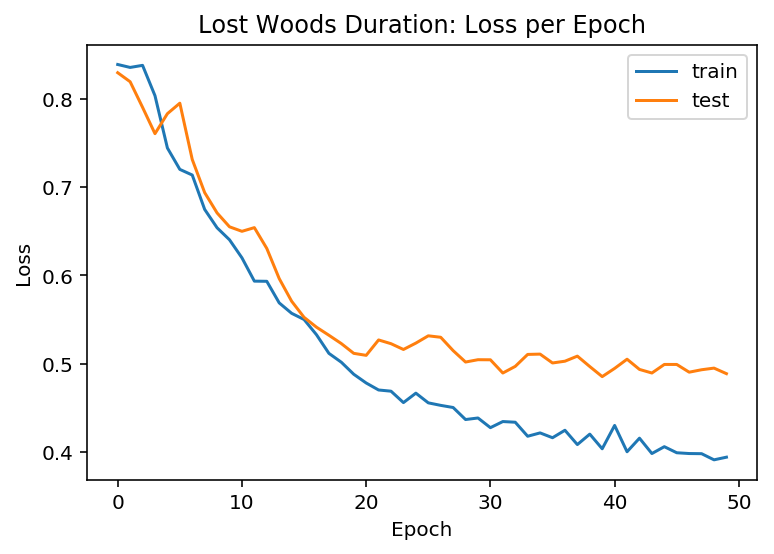

In [242]:
dataset = Song_of_Storms[['pitch_midi_value', 'velocity', 'duration_value']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
ss_test_y_d = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

ss_model_d = Sequential()
ss_model_d.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
ss_model_d.add(Dense(50))
ss_model_d.add(Dense(1))
ss_model_d.compile(loss='mae', optimizer='adam')
ss_history_d = ss_model_d.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(ss_history_d.history['loss'], label='train')
plt.plot(ss_history_d.history['val_loss'], label='test')
plt.legend()
plt.title('Song of Storms Duration: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [243]:
actual = list(ss_test_y_d)

predicted = []
for item in ss_model_d.predict(test_X):
    predicted.append(item[0])

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,0.5,0.657557
1,0.5,0.625963
2,3.0,2.608362
3,0.5,0.198987
4,2.0,1.770271


In [244]:
(comparison['predicted'].min(), comparison['predicted'].max()), (comparison['actual'].min(), comparison['actual'].max())

((0.19898714125156403, 3.4400765895843506), (0.5, 3.0))

In [245]:
rmse = np.sqrt(mean_squared_error(predicted, actual))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.614


### Training on Gerudo Valley

In [246]:
Gerudo_Valley = df[df['song'] == df['song'].value_counts().index[1]]

Train on 904 samples, validate on 387 samples
Epoch 1/50
 - 4s - loss: 47.4019 - val_loss: 42.7005
Epoch 2/50
 - 0s - loss: 38.5073 - val_loss: 32.0328
Epoch 3/50
 - 0s - loss: 27.1854 - val_loss: 20.2132
Epoch 4/50
 - 0s - loss: 14.6897 - val_loss: 8.0238
Epoch 5/50
 - 0s - loss: 7.5330 - val_loss: 8.2643
Epoch 6/50
 - 0s - loss: 7.9089 - val_loss: 7.4602
Epoch 7/50
 - 0s - loss: 7.4667 - val_loss: 7.3287
Epoch 8/50
 - 0s - loss: 7.4167 - val_loss: 7.3727
Epoch 9/50
 - 0s - loss: 7.4139 - val_loss: 7.3989
Epoch 10/50
 - 0s - loss: 7.4220 - val_loss: 7.3904
Epoch 11/50
 - 0s - loss: 7.4228 - val_loss: 7.3715
Epoch 12/50
 - 0s - loss: 7.4213 - val_loss: 7.3490
Epoch 13/50
 - 0s - loss: 7.4183 - val_loss: 7.3417
Epoch 14/50
 - 0s - loss: 7.4122 - val_loss: 7.3332
Epoch 15/50
 - 0s - loss: 7.3964 - val_loss: 7.3132
Epoch 16/50
 - 0s - loss: 7.3388 - val_loss: 7.2830
Epoch 17/50
 - 0s - loss: 7.2791 - val_loss: 7.3826
Epoch 18/50
 - 0s - loss: 7.2996 - val_loss: 7.2445
Epoch 19/50
 - 0s - 

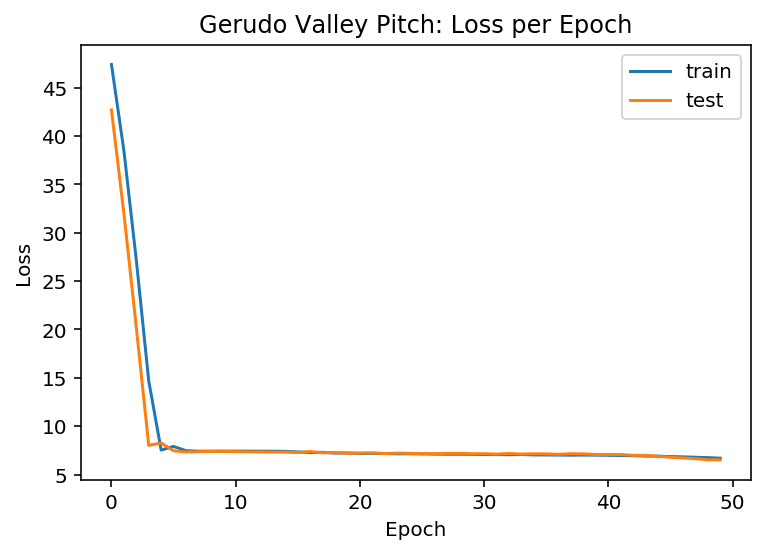

In [247]:
dataset = Gerudo_Valley[['velocity', 'duration_value', 'pitch_midi_value']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
gv_test_y_p = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

gv_model_p = Sequential()
gv_model_p.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
gv_model_p.add(Dense(50))
gv_model_p.add(Dense(1))
gv_model_p.compile(loss='mae', optimizer='adam')
gv_history_p = gv_model_p.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(gv_history_p.history['loss'], label='train')
plt.plot(gv_history_p.history['val_loss'], label='test')
plt.legend()
plt.title('Gerudo Valley Pitch: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [248]:
actual = list(gv_test_y_p)

predicted = []
for item in gv_model_p.predict(test_X):
    predicted.append(round(item[0]))

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,47.0,45.0
1,52.0,50.0
2,40.0,48.0
3,38.0,49.0
4,52.0,50.0


Train on 904 samples, validate on 387 samples
Epoch 1/50
 - 5s - loss: 71.6922 - val_loss: 67.0650
Epoch 2/50
 - 0s - loss: 63.0173 - val_loss: 55.9446
Epoch 3/50
 - 0s - loss: 50.3710 - val_loss: 41.8838
Epoch 4/50
 - 0s - loss: 35.0805 - val_loss: 24.9856
Epoch 5/50
 - 0s - loss: 17.0026 - val_loss: 6.8545
Epoch 6/50
 - 0s - loss: 6.5836 - val_loss: 7.1009
Epoch 7/50
 - 0s - loss: 6.3135 - val_loss: 5.8757
Epoch 8/50
 - 0s - loss: 6.0479 - val_loss: 5.6695
Epoch 9/50
 - 0s - loss: 5.8734 - val_loss: 5.6310
Epoch 10/50
 - 0s - loss: 5.7878 - val_loss: 5.6048
Epoch 11/50
 - 0s - loss: 5.7986 - val_loss: 5.6494
Epoch 12/50
 - 0s - loss: 5.8473 - val_loss: 5.6404
Epoch 13/50
 - 0s - loss: 5.8236 - val_loss: 5.6484
Epoch 14/50
 - 0s - loss: 5.8234 - val_loss: 5.6358
Epoch 15/50
 - 0s - loss: 5.8022 - val_loss: 5.6239
Epoch 16/50
 - 0s - loss: 5.7903 - val_loss: 5.6491
Epoch 17/50
 - 0s - loss: 5.7979 - val_loss: 5.6701
Epoch 18/50
 - 0s - loss: 5.8241 - val_loss: 5.5859
Epoch 19/50
 - 0s 

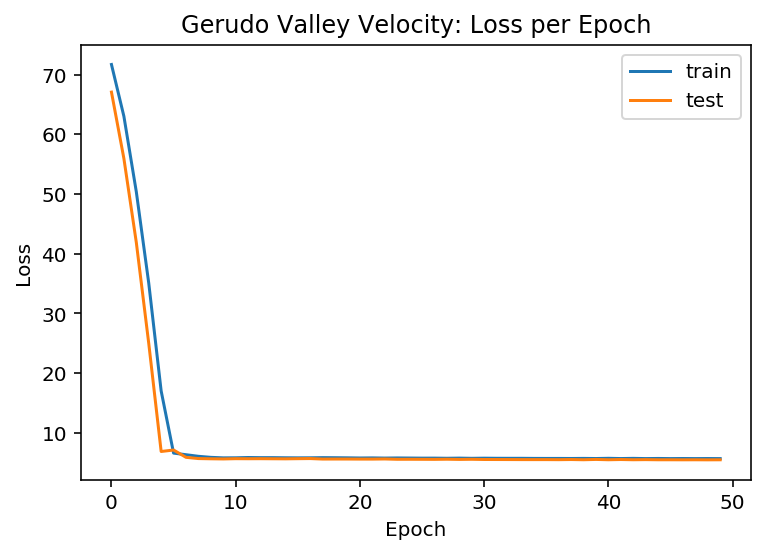

In [249]:
dataset = Gerudo_Valley[['duration_value', 'pitch_midi_value', 'velocity']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
gv_test_y_v = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

gv_model_v = Sequential()
gv_model_v.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
gv_model_v.add(Dense(50))
gv_model_v.add(Dense(1))
gv_model_v.compile(loss='mae', optimizer='adam')
gv_history_v = gv_model_v.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(gv_history_v.history['loss'], label='train')
plt.plot(gv_history_v.history['val_loss'], label='test')
plt.legend()
plt.title('Gerudo Valley Velocity: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [250]:
actual = list(gv_test_y_v)

predicted = []
for item in gv_model_v.predict(test_X):
    predicted.append(round(item[0]))

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,67.0,71.0
1,77.0,75.0
2,75.0,71.0
3,75.0,72.0
4,96.0,75.0


Train on 904 samples, validate on 387 samples
Epoch 1/50
 - 5s - loss: 0.2903 - val_loss: 0.2632
Epoch 2/50
 - 0s - loss: 0.1842 - val_loss: 0.1971
Epoch 3/50
 - 0s - loss: 0.1643 - val_loss: 0.1973
Epoch 4/50
 - 0s - loss: 0.1625 - val_loss: 0.1950
Epoch 5/50
 - 0s - loss: 0.1644 - val_loss: 0.1988
Epoch 6/50
 - 0s - loss: 0.1698 - val_loss: 0.2097
Epoch 7/50
 - 0s - loss: 0.1748 - val_loss: 0.1969
Epoch 8/50
 - 0s - loss: 0.1594 - val_loss: 0.1956
Epoch 9/50
 - 0s - loss: 0.1601 - val_loss: 0.2018
Epoch 10/50
 - 0s - loss: 0.1639 - val_loss: 0.1866
Epoch 11/50
 - 0s - loss: 0.1554 - val_loss: 0.1926
Epoch 12/50
 - 0s - loss: 0.1531 - val_loss: 0.1841
Epoch 13/50
 - 0s - loss: 0.1507 - val_loss: 0.1881
Epoch 14/50
 - 0s - loss: 0.1612 - val_loss: 0.2126
Epoch 15/50
 - 0s - loss: 0.1606 - val_loss: 0.2246
Epoch 16/50
 - 0s - loss: 0.1821 - val_loss: 0.2769
Epoch 17/50
 - 0s - loss: 0.2076 - val_loss: 0.1903
Epoch 18/50
 - 0s - loss: 0.1760 - val_loss: 0.1865
Epoch 19/50
 - 0s - loss: 0

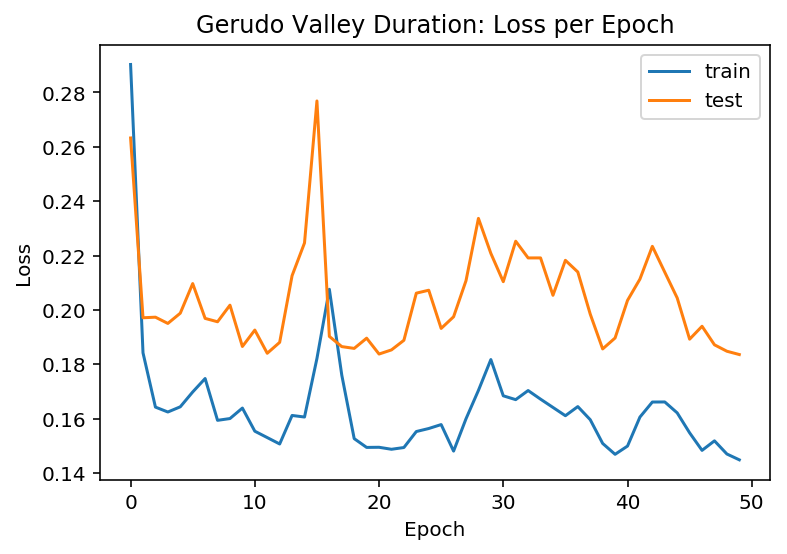

In [251]:
dataset = Gerudo_Valley[['pitch_midi_value', 'velocity', 'duration_value']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
gv_test_y_d = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

gv_model_d = Sequential()
gv_model_d.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
gv_model_d.add(Dense(50))
gv_model_d.add(Dense(1))
gv_model_d.compile(loss='mae', optimizer='adam')
gv_history_d = gv_model_d.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(gv_history_d.history['loss'], label='train')
plt.plot(gv_history_d.history['val_loss'], label='test')
plt.legend()
plt.title('Gerudo Valley Duration: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [252]:
actual = list(gv_test_y_d)

predicted = []
for item in gv_model_d.predict(test_X):
    predicted.append(item[0])

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,0.25,0.244967
1,0.25,0.271771
2,0.25,0.258195
3,0.25,0.312993
4,0.50,0.500973


### Training on Great Fairy Fountain

In [253]:
Great_Fairy_Fountain = df[df['song'] == df['song'].value_counts().index[7]]

Train on 230 samples, validate on 99 samples
Epoch 1/50
 - 5s - loss: 73.9023 - val_loss: 73.8362
Epoch 2/50
 - 0s - loss: 71.9729 - val_loss: 71.8253
Epoch 3/50
 - 0s - loss: 69.9165 - val_loss: 69.5833
Epoch 4/50
 - 0s - loss: 67.5827 - val_loss: 66.9738
Epoch 5/50
 - 0s - loss: 64.8729 - val_loss: 64.0115
Epoch 6/50
 - 0s - loss: 61.8082 - val_loss: 60.6439
Epoch 7/50
 - 0s - loss: 58.3265 - val_loss: 56.9385
Epoch 8/50
 - 0s - loss: 54.5580 - val_loss: 53.0142
Epoch 9/50
 - 0s - loss: 50.5882 - val_loss: 48.9523
Epoch 10/50
 - 0s - loss: 46.4640 - val_loss: 44.6583
Epoch 11/50
 - 0s - loss: 42.1103 - val_loss: 40.1610
Epoch 12/50
 - 0s - loss: 37.5345 - val_loss: 35.3756
Epoch 13/50
 - 0s - loss: 32.6912 - val_loss: 30.4693
Epoch 14/50
 - 0s - loss: 27.9438 - val_loss: 25.9392
Epoch 15/50
 - 0s - loss: 23.6494 - val_loss: 21.6754
Epoch 16/50
 - 0s - loss: 19.5061 - val_loss: 17.5665
Epoch 17/50
 - 0s - loss: 15.9637 - val_loss: 14.1983
Epoch 18/50
 - 0s - loss: 13.3951 - val_loss: 

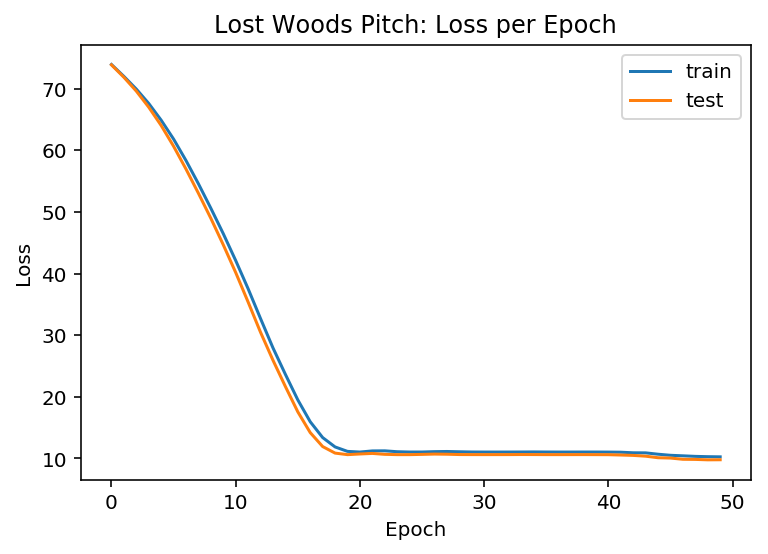

In [254]:
dataset = Great_Fairy_Fountain[['velocity', 'duration_value', 'pitch_midi_value']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
gff_test_y_p = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

gff_model_p = Sequential()
gff_model_p.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
gff_model_p.add(Dense(50))
gff_model_p.add(Dense(1))
gff_model_p.compile(loss='mae', optimizer='adam')
gff_history_p = gff_model_p.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(gff_history_p.history['loss'], label='train')
plt.plot(gff_history_p.history['val_loss'], label='test')
plt.legend()
plt.title('Great Fairy Fountain Pitch: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [255]:
actual = list(gff_test_y_p)

predicted = []
for item in gff_model_p.predict(test_X):
    predicted.append(round(item[0]))

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,88.0,74.0
1,53.0,75.0
2,57.0,73.0
3,64.0,74.0
4,74.0,78.0


Train on 230 samples, validate on 99 samples
Epoch 1/50
 - 5s - loss: 55.9232 - val_loss: 54.9526
Epoch 2/50
 - 0s - loss: 53.6180 - val_loss: 52.4477
Epoch 3/50
 - 0s - loss: 51.0235 - val_loss: 49.5908
Epoch 4/50
 - 0s - loss: 48.0598 - val_loss: 46.3254
Epoch 5/50
 - 0s - loss: 44.6833 - val_loss: 42.6653
Epoch 6/50
 - 0s - loss: 40.9251 - val_loss: 38.6755
Epoch 7/50
 - 0s - loss: 36.8682 - val_loss: 34.5020
Epoch 8/50
 - 0s - loss: 32.6823 - val_loss: 30.2675
Epoch 9/50
 - 0s - loss: 28.4061 - val_loss: 25.9188
Epoch 10/50
 - 0s - loss: 23.9965 - val_loss: 21.3257
Epoch 11/50
 - 0s - loss: 19.3185 - val_loss: 16.4556
Epoch 12/50
 - 0s - loss: 14.3472 - val_loss: 11.4936
Epoch 13/50
 - 0s - loss: 9.8824 - val_loss: 8.2843
Epoch 14/50
 - 0s - loss: 7.7235 - val_loss: 7.1888
Epoch 15/50
 - 0s - loss: 7.0384 - val_loss: 6.3040
Epoch 16/50
 - 0s - loss: 6.6222 - val_loss: 5.6487
Epoch 17/50
 - 0s - loss: 6.7985 - val_loss: 6.1460
Epoch 18/50
 - 0s - loss: 6.7822 - val_loss: 5.7213
Epoc

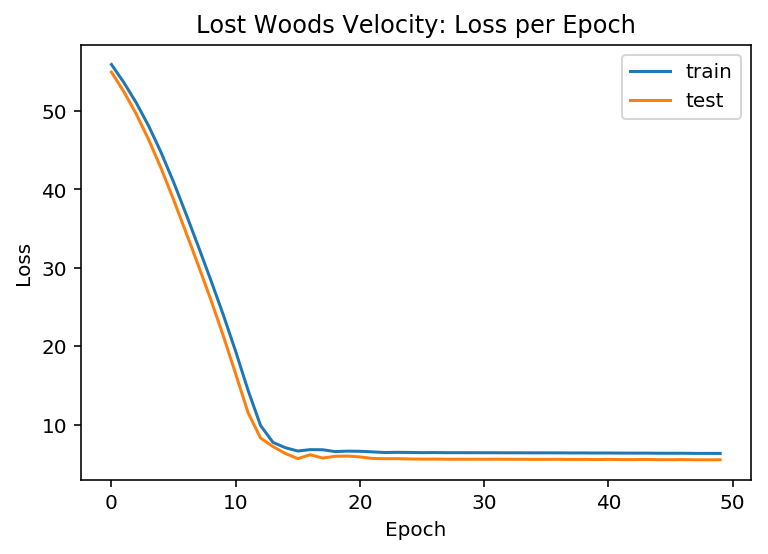

In [256]:
dataset = Great_Fairy_Fountain[['duration_value', 'pitch_midi_value', 'velocity']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
gff_test_y_v = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

gff_model_v = Sequential()
gff_model_v.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
gff_model_v.add(Dense(50))
gff_model_v.add(Dense(1))
gff_model_v.compile(loss='mae', optimizer='adam')
gff_history_v = gff_model_v.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(gff_history_v.history['loss'], label='train')
plt.plot(gff_history_v.history['val_loss'], label='test')
plt.legend()
plt.title('Great Fairy Fountain Velocity: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [257]:
actual = list(gff_test_y_v)

predicted = []
for item in gff_model_v.predict(test_X):
    predicted.append(round(item[0]))

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,62.0,62.0
1,62.0,62.0
2,62.0,62.0
3,62.0,62.0
4,45.0,62.0


Train on 230 samples, validate on 99 samples
Epoch 1/50
 - 5s - loss: 0.6276 - val_loss: 0.4998
Epoch 2/50
 - 0s - loss: 0.3854 - val_loss: 0.2573
Epoch 3/50
 - 0s - loss: 0.2936 - val_loss: 0.1863
Epoch 4/50
 - 0s - loss: 0.2247 - val_loss: 0.1892
Epoch 5/50
 - 0s - loss: 0.1814 - val_loss: 0.2040
Epoch 6/50
 - 0s - loss: 0.1888 - val_loss: 0.1742
Epoch 7/50
 - 0s - loss: 0.1638 - val_loss: 0.1668
Epoch 8/50
 - 0s - loss: 0.1604 - val_loss: 0.1342
Epoch 9/50
 - 0s - loss: 0.1462 - val_loss: 0.1237
Epoch 10/50
 - 0s - loss: 0.1408 - val_loss: 0.1363
Epoch 11/50
 - 0s - loss: 0.1401 - val_loss: 0.1164
Epoch 12/50
 - 0s - loss: 0.1388 - val_loss: 0.1244
Epoch 13/50
 - 0s - loss: 0.1325 - val_loss: 0.1075
Epoch 14/50
 - 0s - loss: 0.1235 - val_loss: 0.1065
Epoch 15/50
 - 0s - loss: 0.1197 - val_loss: 0.1056
Epoch 16/50
 - 0s - loss: 0.1182 - val_loss: 0.1222
Epoch 17/50
 - 0s - loss: 0.1317 - val_loss: 0.1157
Epoch 18/50
 - 0s - loss: 0.1239 - val_loss: 0.1231
Epoch 19/50
 - 0s - loss: 0.

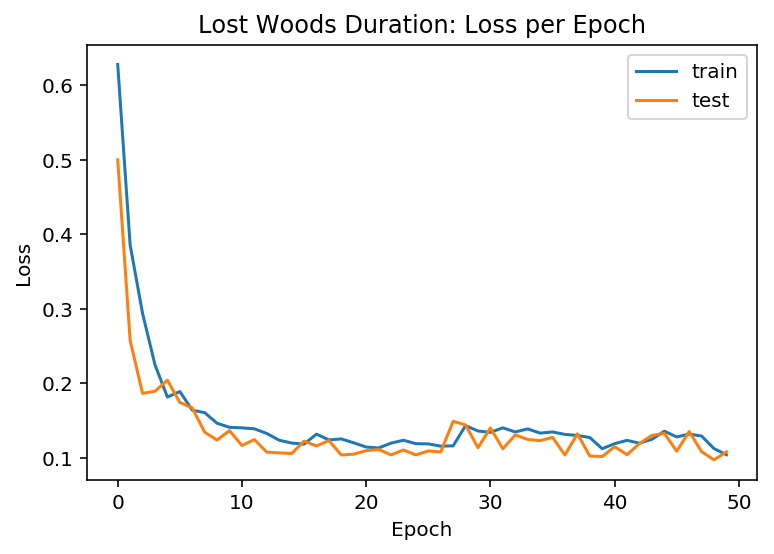

In [258]:
dataset = Great_Fairy_Fountain[['pitch_midi_value', 'velocity', 'duration_value']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:round(reframed.shape[0] * 0.70), :]
test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
gff_test_y_d = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

gff_model_d = Sequential()
gff_model_d.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
gff_model_d.add(Dense(50))
gff_model_d.add(Dense(1))
gff_model_d.compile(loss='mae', optimizer='adam')
gff_history_d = gff_model_d.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

plt.plot(gff_history_d.history['loss'], label='train')
plt.plot(gff_history_d.history['val_loss'], label='test')
plt.legend()
plt.title('Great Fairy Fountain Duration: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [259]:
actual = list(gff_test_y_d)

predicted = []
for item in gff_model_d.predict(test_X):
    predicted.append(item[0])

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

,actual,predicted
0,1.00,1.005431
1,0.25,0.306805
2,0.25,0.268050
3,1.25,0.270296
4,0.25,0.226982


In [260]:
(comparison['predicted'].min(), comparison['predicted'].max()), (comparison['actual'].min(), comparison['actual'].max())

((0.22357536852359772, 1.082292914390564), (0.25, 1.25))

In [261]:
rmse = np.sqrt(mean_squared_error(predicted, actual))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.244


### Training on All Songs

In [262]:
All_Songs = df.copy()

In [263]:
dataset = All_Songs[['velocity', 'duration_value', 'pitch_midi_value']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:, :]
#test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
#test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
#as_test_y_p = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

as_model_p = Sequential()
as_model_p.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
as_model_p.add(Dense(50))
as_model_p.add(Dense(1))
as_model_p.compile(loss='mae', optimizer='adam')
as_history_p = as_model_p.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)

Epoch 1/50
 - 6s - loss: 25.2884
Epoch 2/50
 - 1s - loss: 11.0970
Epoch 3/50
 - 1s - loss: 11.0492
Epoch 4/50
 - 1s - loss: 10.9445
Epoch 5/50
 - 1s - loss: 10.8913
Epoch 6/50
 - 1s - loss: 10.9153
Epoch 7/50
 - 1s - loss: 10.8615
Epoch 8/50
 - 1s - loss: 10.8656
Epoch 9/50
 - 1s - loss: 10.7756
Epoch 10/50
 - 1s - loss: 10.7844
Epoch 11/50
 - 1s - loss: 10.7658
Epoch 12/50
 - 1s - loss: 10.7343
Epoch 13/50
 - 1s - loss: 10.6407
Epoch 14/50
 - 1s - loss: 10.7662
Epoch 15/50
 - 1s - loss: 10.6448
Epoch 16/50
 - 1s - loss: 10.5883
Epoch 17/50
 - 1s - loss: 10.5600
Epoch 18/50
 - 1s - loss: 10.5729
Epoch 19/50
 - 1s - loss: 10.5516
Epoch 20/50
 - 1s - loss: 10.5957
Epoch 21/50
 - 1s - loss: 10.5482
Epoch 22/50
 - 1s - loss: 10.5028
Epoch 23/50
 - 1s - loss: 10.4971
Epoch 24/50
 - 1s - loss: 10.5176
Epoch 25/50
 - 1s - loss: 10.4973
Epoch 26/50
 - 1s - loss: 10.5040
Epoch 27/50
 - 1s - loss: 10.4976
Epoch 28/50
 - 1s - loss: 10.4737
Epoch 29/50
 - 1s - loss: 10.5107
Epoch 30/50
 - 1s - los

In [264]:
dataset = All_Songs[['duration_value', 'pitch_midi_value', 'velocity']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:, :]
#test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
#test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
#as_test_y_v = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

as_model_v = Sequential()
as_model_v.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
as_model_v.add(Dense(50))
as_model_v.add(Dense(1))
as_model_v.compile(loss='mae', optimizer='adam')
as_history_v = as_model_v.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)

Epoch 1/50
 - 6s - loss: 32.2146
Epoch 2/50
 - 1s - loss: 12.4205
Epoch 3/50
 - 1s - loss: 12.0040
Epoch 4/50
 - 1s - loss: 11.8457
Epoch 5/50
 - 1s - loss: 11.8658
Epoch 6/50
 - 1s - loss: 11.6598
Epoch 7/50
 - 1s - loss: 11.8496
Epoch 8/50
 - 1s - loss: 11.7257
Epoch 9/50
 - 1s - loss: 11.6802
Epoch 10/50
 - 1s - loss: 11.5860
Epoch 11/50
 - 1s - loss: 11.6073
Epoch 12/50
 - 1s - loss: 11.6234
Epoch 13/50
 - 1s - loss: 11.4986
Epoch 14/50
 - 1s - loss: 11.6514
Epoch 15/50
 - 1s - loss: 11.4393
Epoch 16/50
 - 1s - loss: 11.5006
Epoch 17/50
 - 1s - loss: 11.5324
Epoch 18/50
 - 1s - loss: 11.3197
Epoch 19/50
 - 1s - loss: 11.3766
Epoch 20/50
 - 1s - loss: 11.5101
Epoch 21/50
 - 1s - loss: 11.4620
Epoch 22/50
 - 1s - loss: 11.5890
Epoch 23/50
 - 1s - loss: 11.3274
Epoch 24/50
 - 1s - loss: 11.4646
Epoch 25/50
 - 1s - loss: 11.4759
Epoch 26/50
 - 1s - loss: 11.3760
Epoch 27/50
 - 1s - loss: 11.4677
Epoch 28/50
 - 1s - loss: 11.5835
Epoch 29/50
 - 1s - loss: 11.3540
Epoch 30/50
 - 1s - los

In [266]:
actual = list(as_test_y_v)

predicted = []
for item in as_model_v.predict(test_X):
    predicted.append(round(item[0]))

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

In [ ]:
dataset = All_Songs[['pitch_midi_value', 'velocity', 'duration_value']]

values = dataset.values
values = values.astype('float32')

# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
#reframed = series_to_supervised(scaled, 1, 1)

reframed = series_to_supervised(values, 1, 1)
##print(reframed.head())

values = reframed.values
train = values[:, :]
#test = values[round(reframed.shape[0] * 0.70):, :]

train_X, train_y = train[:, :-1], train[:, -1]
#test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# saving test_y
#as_test_y_d = test_y

##print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

as_model_d = Sequential()
as_model_d.add(LSTM(200, input_shape=(train_X.shape[1], train_X.shape[2])))
as_model_d.add(Dense(50))
as_model_d.add(Dense(1))
as_model_d.compile(loss='mae', optimizer='adam')
as_history_d = as_model_d.fit(train_X, train_y, epochs=50, batch_size=72, verbose=2, shuffle=False)

In [ ]:
actual = list(as_test_y_d)

predicted = []
for item in as_model_d.predict(test_X):
    predicted.append(item[0])

comparison = pd.DataFrame({
    'actual': actual,
    'predicted': predicted
})

comparison.head()

## Simulating Zelda Music

In [325]:
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)

random_state=42

dataset = Song_of_Storms[['duration_value', 'pitch_midi_value', 'velocity']].reset_index(drop=True).loc[:1, :]
for i in range(200):
    values = dataset.values
    values = values.astype('float32')
    reframed = series_to_supervised(values, 1, 1)
    values = reframed.values
    test_X, test_y = values[:, :-1], values[:, -1]
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    if int(round(gv_model_p.predict(test_X)[0][0])) >= 0:
        gv_p = int(round(gv_model_p.predict(test_X)[0][0]))
    else:
        gv_p = 0    
    if int(round(gv_model_v.predict(test_X)[0][0])) >= 0:
        gv_v = int(round(gv_model_v.predict(test_X)[0][0]))
    else:
        gv_v = 0
    if gv_model_d.predict(test_X)[0][0] >= 0:
        gv_d = int(round(gv_model_d.predict(test_X)[0][0] * 1024))
    else:
        gv_d = 0
            
    if int(round(lw_model_p.predict(test_X)[0][0])) >= 0:
        lw_p = int(round(lw_model_p.predict(test_X)[0][0]))
    else:
        lw_p = 0    
    if int(round(lw_model_v.predict(test_X)[0][0])) >= 0:
        lw_v = int(round(lw_model_v.predict(test_X)[0][0]))
    else:
        lw_v = 0
    if lw_model_d.predict(test_X)[0][0] >= 0:
        lw_d = int(round(lw_model_d.predict(test_X)[0][0] * 1024))
    else:
        lw_d = 0
        
    if int(round(mt_model_p.predict(test_X)[0][0])) >= 0:
        mt_p = int(round(mt_model_p.predict(test_X)[0][0]))
    else:
        mt_p = 0    
    if int(round(mt_model_v.predict(test_X)[0][0])) >= 0:
        mt_v = int(round(mt_model_v.predict(test_X)[0][0]))
    else:
        mt_v = 0
    if mt_model_d.predict(test_X)[0][0] >= 0:
        mt_d = int(round(mt_model_d.predict(test_X)[0][0] * 1024))
    else:
        mt_d = 0
        
    if int(round(zt_model_p.predict(test_X)[0][0])) >= 0:
        zt_p = int(round(zt_model_p.predict(test_X)[0][0]))
    else:
        zt_p = 0    
    if int(round(zt_model_v.predict(test_X)[0][0])) >= 0:
        zt_v = int(round(zt_model_v.predict(test_X)[0][0]))
    else:
        zt_v = 0
    if zt_model_d.predict(test_X)[0][0] >= 0:
        zt_d = int(round(zt_model_d.predict(test_X)[0][0] * 1024))
    else:
        zt_d = 0
    
    if int(round(ss_model_p.predict(test_X)[0][0])) >= 0:
        ss_p = int(round(ss_model_p.predict(test_X)[0][0]))
    else:
        ss_p = 0    
    if int(round(ss_model_v.predict(test_X)[0][0])) >= 0:
        ss_v = int(round(ss_model_v.predict(test_X)[0][0]))
    else:
        ss_v = 0
    if ss_model_d.predict(test_X)[0][0] >= 0:
        ss_d = int(round(ss_model_d.predict(test_X)[0][0] * 1024))
    else:
        ss_d = 0

    if int(round(gff_model_p.predict(test_X)[0][0])) >= 0:
        gff_p = int(round(gff_model_p.predict(test_X)[0][0]))
    else:
        gff_p = 0    
    if int(round(gff_model_v.predict(test_X)[0][0])) >= 0:
        gff_v = int(round(gff_model_v.predict(test_X)[0][0]))
    else:
        gff_v = 0
    if gff_model_d.predict(test_X)[0][0] >= 0:
        gff_d = int(round(gff_model_d.predict(test_X)[0][0] * 1024))
    else:
        gff_d = 0
 
    if int(round(as_model_p.predict(test_X)[0][0])) >= 0:
        as_p = int(round(as_model_p.predict(test_X)[0][0]))
    else:
        as_p = 0    
    if int(round(as_model_v.predict(test_X)[0][0])) >= 0:
        as_v = int(round(as_model_v.predict(test_X)[0][0]))
    else:
        as_v = 0
    if as_model_d.predict(test_X)[0][0] >= 0:
        as_d = int(round(as_model_d.predict(test_X)[0][0] * 1024))
    else:
        as_d = 0
        
    #choose = np.random.choice(5)
    #p = [mt_p, lw_p, ss_p, gv_p, gff_p][choose]#int(round(np.mean([mt_p, lw_p, ss_p, gv_p, gff_p])))
    #v = [mt_v, lw_v, ss_v, gv_v, gff_v][choose]#int(round(np.mean([mt_v, lw_v, ss_v, gv_v, gff_v])))
    #d = [mt_d, lw_d, ss_d, gv_d, gff_d][choose]#int(round(np.mean([mt_d, lw_d, ss_d, gv_d, gff_d])))
    
    p = as_p
    v = as_v
    d = as_d
    
    track.append(Message('note_on', note=p, velocity=v, time=d))
    track.append(Message('note_off', note=p, velocity=v, time=d))

    dataset = dataset.drop(0).append({'pitch_midi_value': p, 'velocity': v, 'duration_value': d}, ignore_index=True)

# 50 was added to v in each case except using all data for presentation
mid.save('Neural_Network_midi_3.mid')

## Conclusions and Future Goals

***

<center>**Under Construction**</center>

Pellentesque nisi pretium vehicula ultricies condimentum tellus curabitur vehicula, viverra a ipsum nibh rhoncus enim ultrices, dictumst proin leo pulvinar tristique nullam vulputate adipiscing lacinia nisi ullamcorper mi auctor.

Per vel lobortis cubilia phasellus mi massa pretium, varius ante blandit vitae scelerisque integer curabitur tempor, bibendum venenatis rhoncus etiam nisi ac.

<br>
<center>**Under Construction**</center>

***

## References

[1] Midi Files were obtained from here: <https://bitmidi.com/the-legend-of-zelda-ocarina-of-time-zeldas-theme-mid>

[2] Code borrowed from here: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/